In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from scipy import optimize
from folium.plugins import MarkerCluster,HeatMap
import matplotlib.cm as cm

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [152]:
# Reading the pre processed dataset
hcho_data = pd.read_csv('preprocessed_dataset/hcho_data.csv')
hcho_data

HCHO Reading             Location Current Date   Next Date
0          0.000197       Colombo Proper   2019-01-01  2019-01-02
1          0.000197     Deniyaya, Matara   2019-01-01  2019-01-02
2          0.000263  Nuwara Eliya Proper   2019-01-01  2019-01-02
3          0.000263       Colombo Proper   2019-01-02  2019-01-03
4          0.000006     Deniyaya, Matara   2019-01-02  2019-01-03
...             ...                  ...          ...         ...
12777      0.000117        Jaffna Proper   2023-12-30  2023-12-31
12778      0.000117   Bibile, Monaragala   2023-12-31  2024-01-01
12779      0.000065    Kurunegala Proper   2023-12-31  2024-01-01
12780      0.000065        Jaffna Proper   2023-12-31  2024-01-01
12781      0.000129   Bibile, Monaragala   2023-01-24  2023-01-25

[12782 rows x 4 columns]

In [153]:
hcho_data['Current Date'] = pd.to_datetime(hcho_data['Current Date'])
hcho_data['Next Date'] = pd.to_datetime(hcho_data['Next Date'])

In [154]:
# Extracting the year and month
hcho_data['Year'] = hcho_data['Current Date'].dt.year
hcho_data['Month'] = hcho_data['Current Date'].dt.month
hcho_data['Week'] = hcho_data['Current Date'].dt.isocalendar().week

In [155]:
# Grouping the data by year and month
seasoned_data = hcho_data.groupby(['Year', 'Month'])['HCHO Reading'].mean().reset_index()

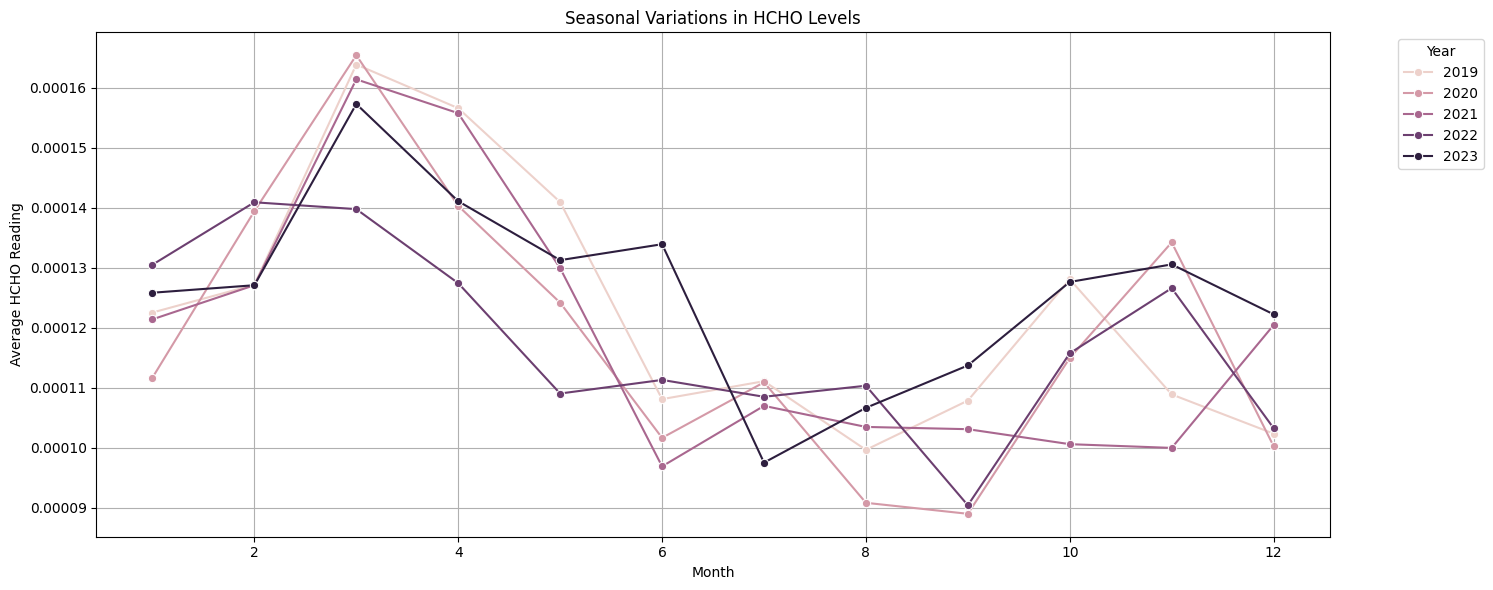

In [156]:
# Plotting seasonal variations
plt.figure(figsize=(15, 6))
sns.lineplot(x="Month", y="HCHO Reading", hue="Year", data=seasoned_data, marker='o')
plt.title('Seasonal Variations in HCHO Levels')
plt.xlabel('Month')
plt.ylabel('Average HCHO Reading')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

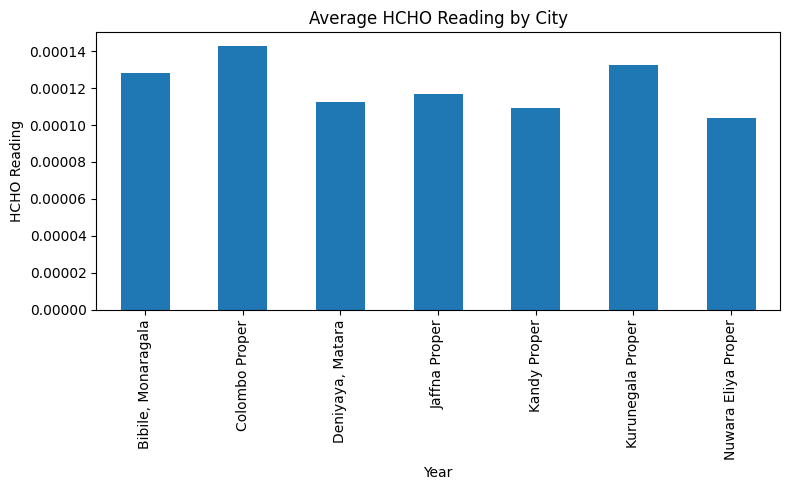

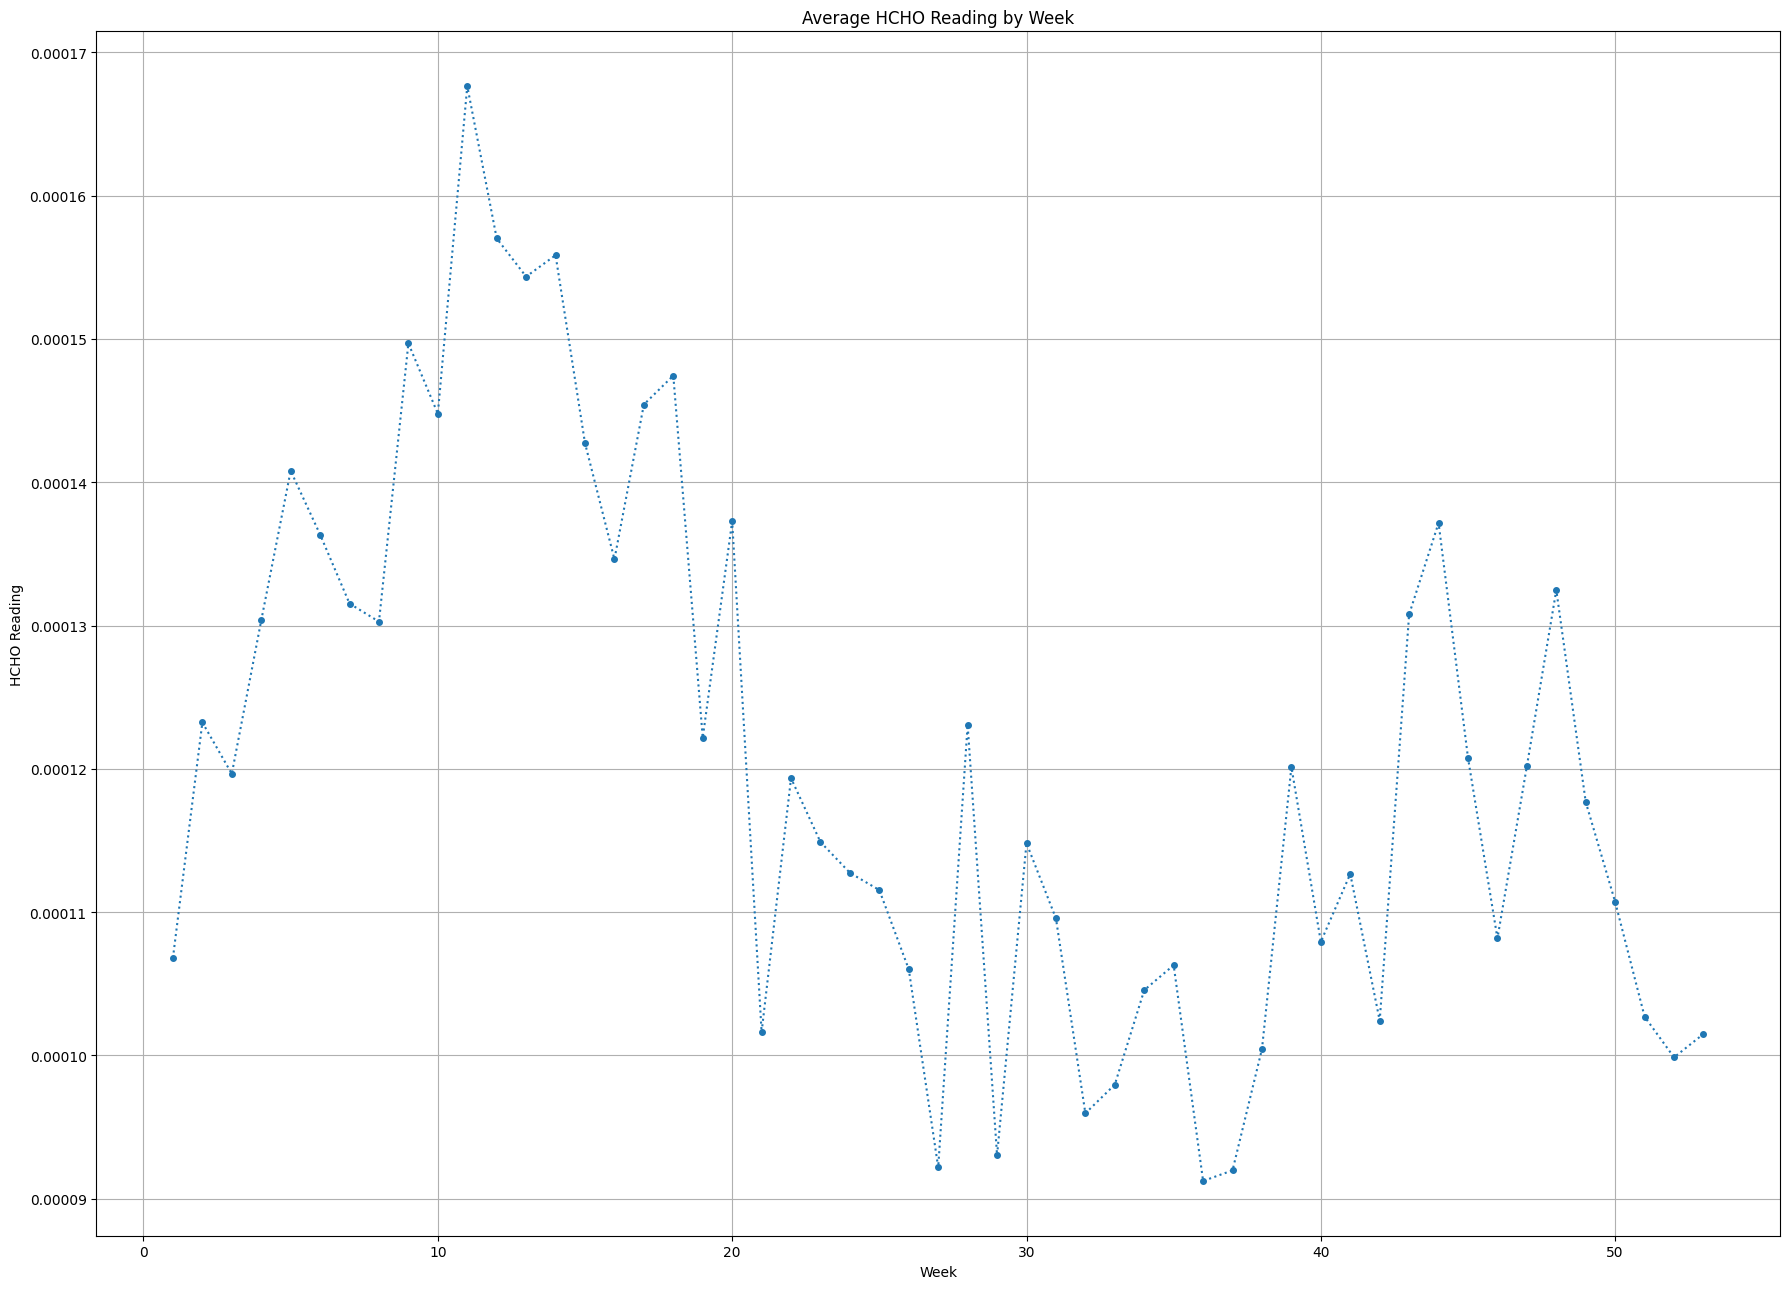

In [157]:
# Plot average HCHO reading by City
plt.figure(figsize=(8, 5))
hcho_data.groupby('Location')['HCHO Reading'].mean().plot(kind='bar')
plt.title('Average HCHO Reading by City')
plt.xlabel('Year')
plt.ylabel('HCHO Reading')
plt.tight_layout()
plt.show()

# Plot average HCHO reading by week
plt.figure(figsize=(18, 13))
hcho_data.groupby('Week')['HCHO Reading'].mean().plot(style='.:', markersize=8)
plt.title('Average HCHO Reading by Week')
plt.xlabel('Week')
plt.ylabel('HCHO Reading')
plt.grid(True)
plt.tight_layout()
plt.show()

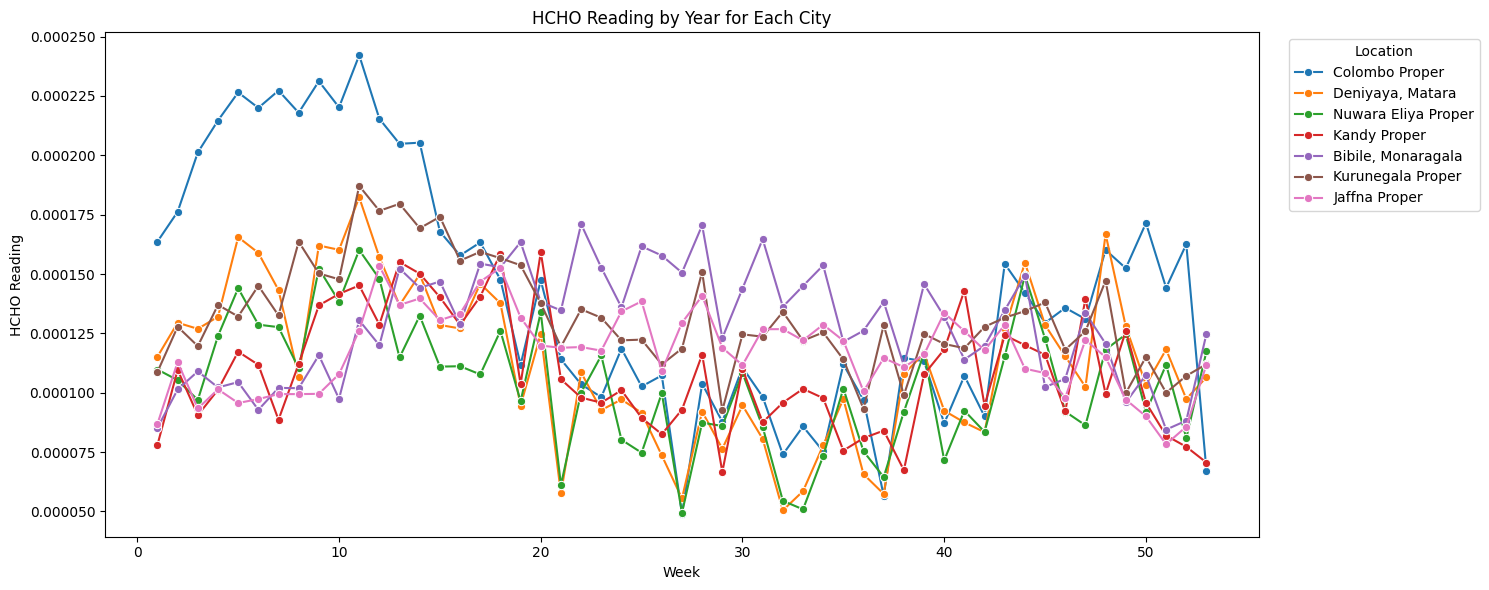

In [158]:
# Plotting the Weekly Means for each city 
plt.figure(figsize=(15, 6))
sns.lineplot(data=hcho_data, x='Week', y='HCHO Reading', hue='Location', marker='o',  errorbar=None)
plt.title('HCHO Reading by Year for Each City')
plt.xlabel('Week')
plt.ylabel('HCHO Reading')
plt.legend(title='Location', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

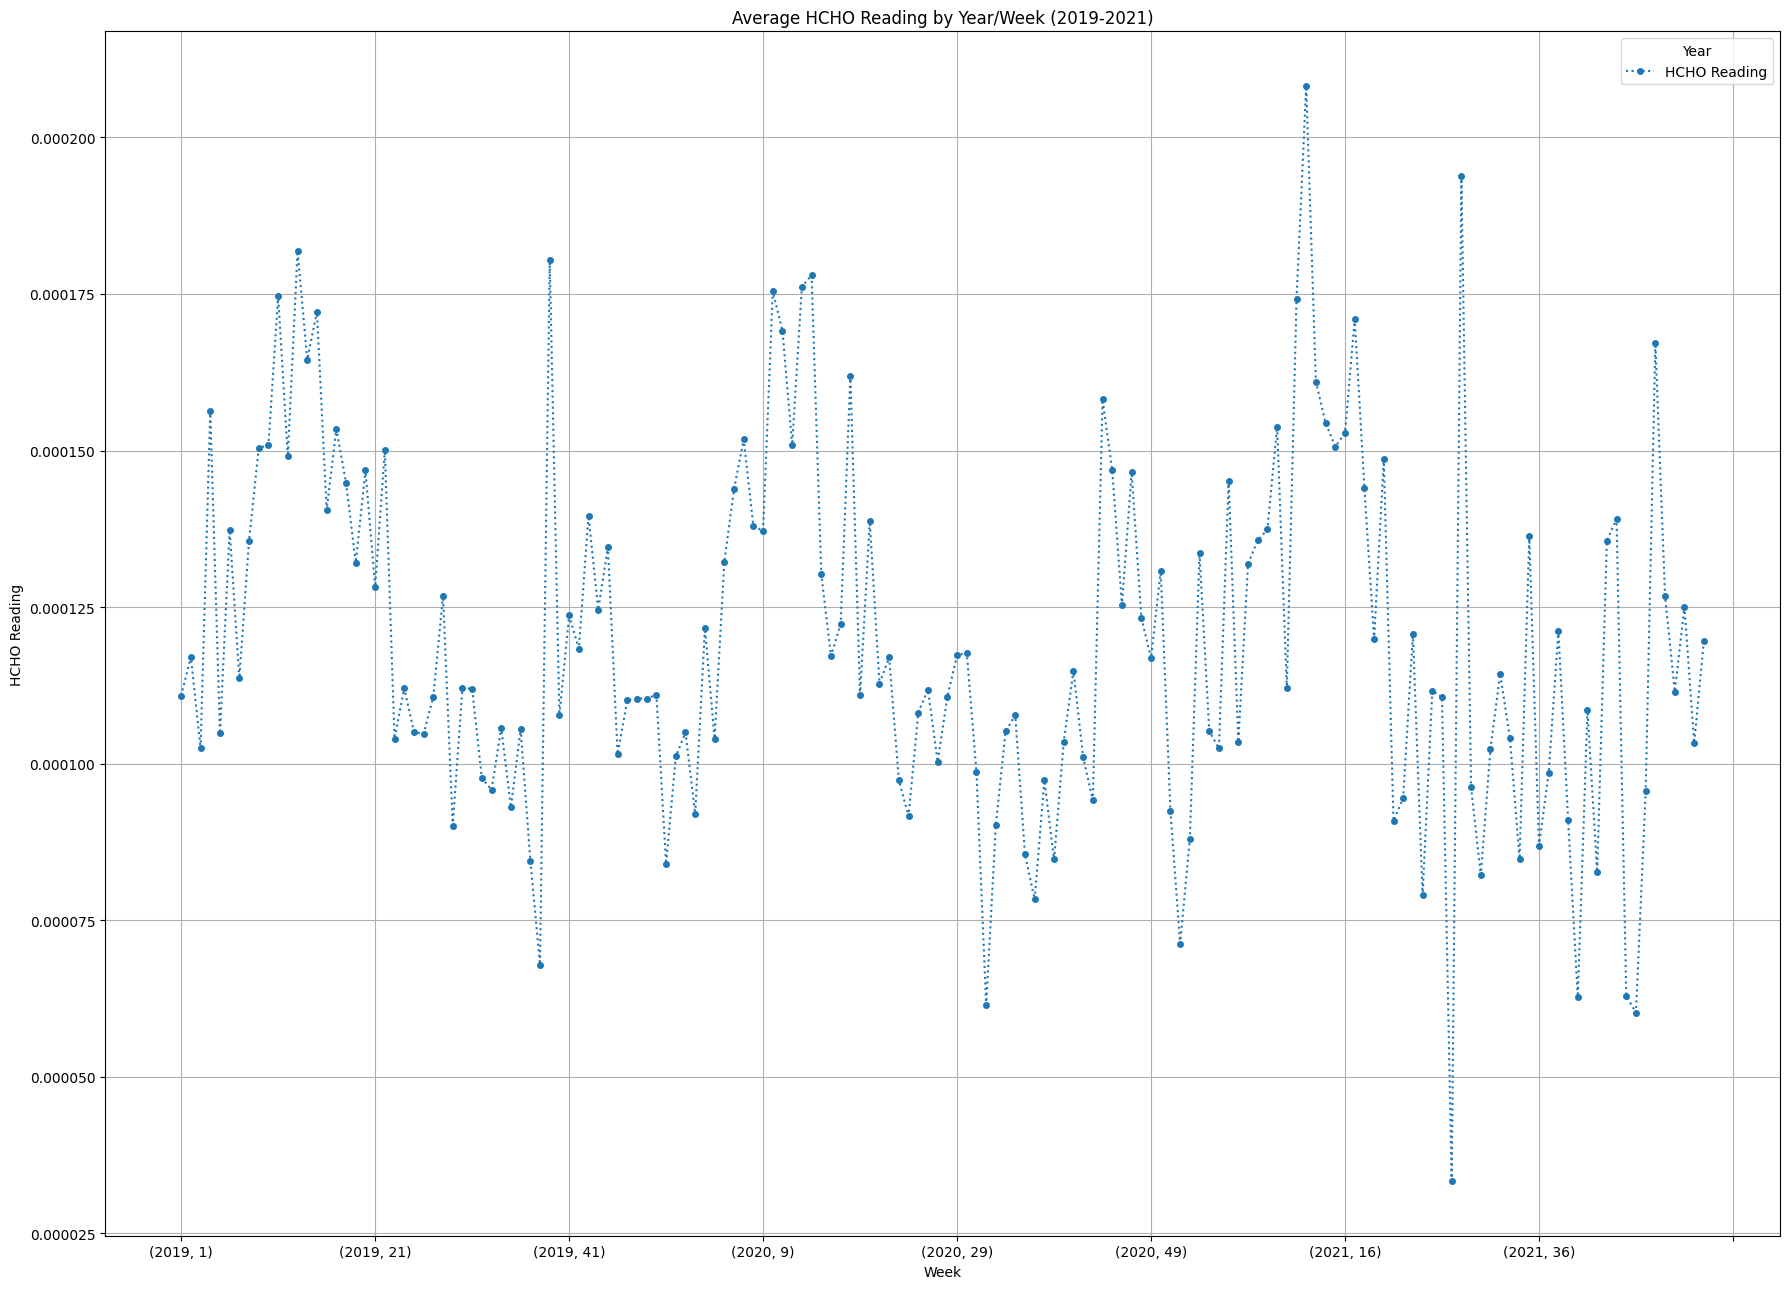

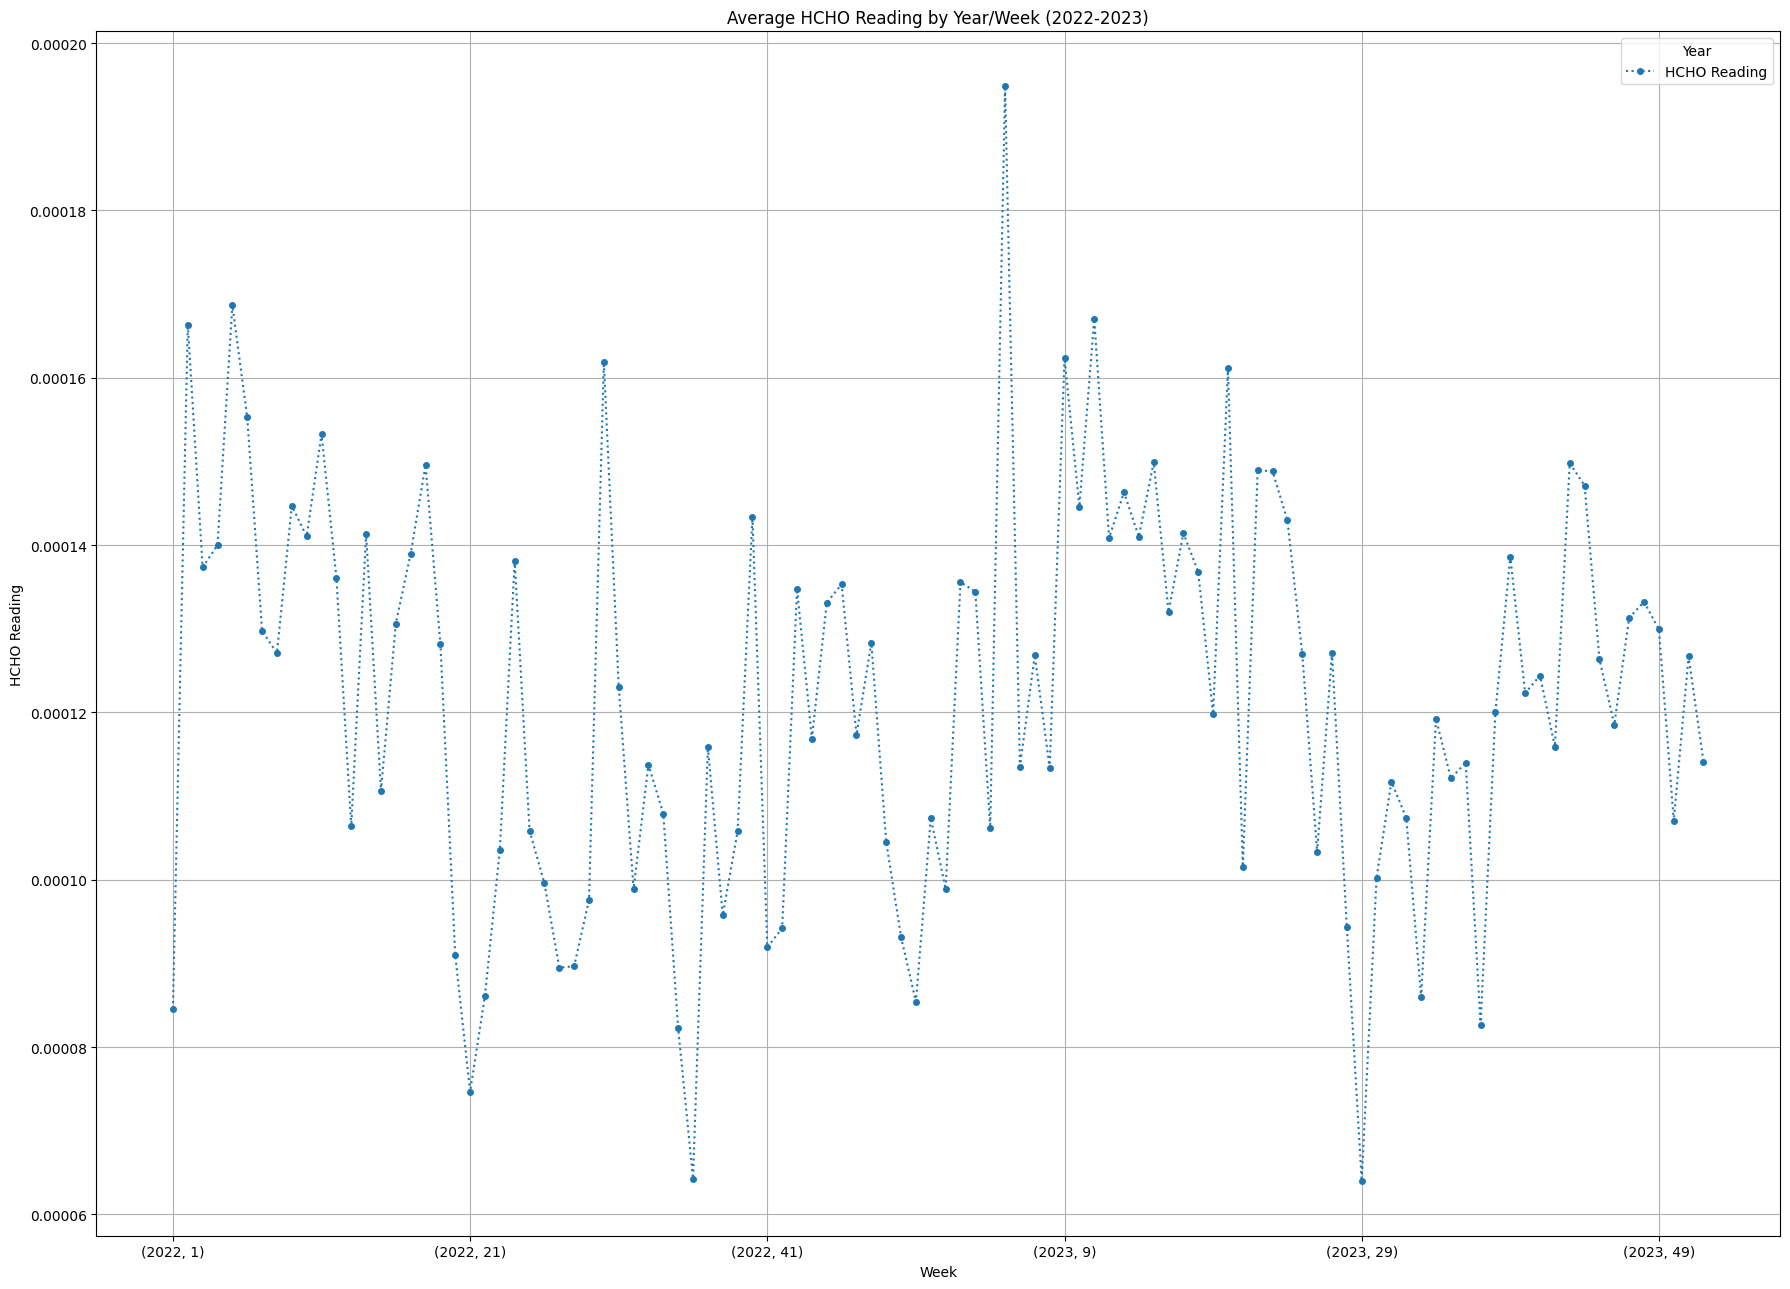

In [159]:
# Filter data for 2019-2021 and 2022-2023
hcho_data_2019_2021 = hcho_data[(hcho_data['Year'] >= 2019) & (hcho_data['Year'] <= 2021)]
hcho_data_2022_2023 = hcho_data[(hcho_data['Year'] >= 2022) & (hcho_data['Year'] <= 2023)]

# Plot average HCHO reading by year/week for 2019-2021
plt.figure(figsize=(18, 13))  # Adjust the size of the figure here
hcho_data_2019_2021.groupby(['Year', 'Week'])['HCHO Reading'].mean().plot(style='.:', markersize=8)
plt.title('Average HCHO Reading by Year/Week (2019-2021)')
plt.ylabel('HCHO Reading')
plt.xlabel('Week')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot average HCHO reading by year/week for 2022-2023
plt.figure(figsize=(18, 13))  # Adjust the size of the figure here
hcho_data_2022_2023.groupby(['Year', 'Week'])['HCHO Reading'].mean().plot(style='.:', markersize=8)
plt.title('Average HCHO Reading by Year/Week (2022-2023)')
plt.ylabel('HCHO Reading')
plt.xlabel('Week')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

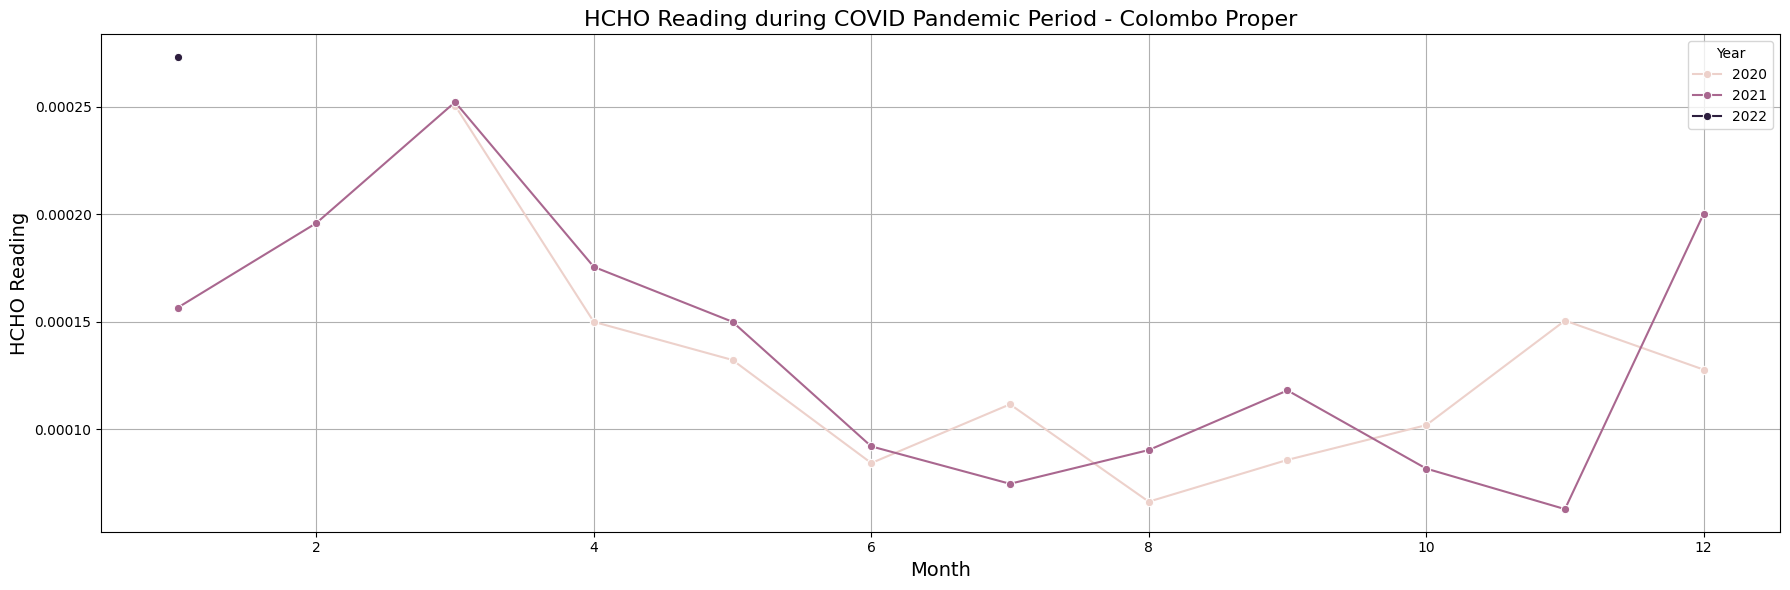

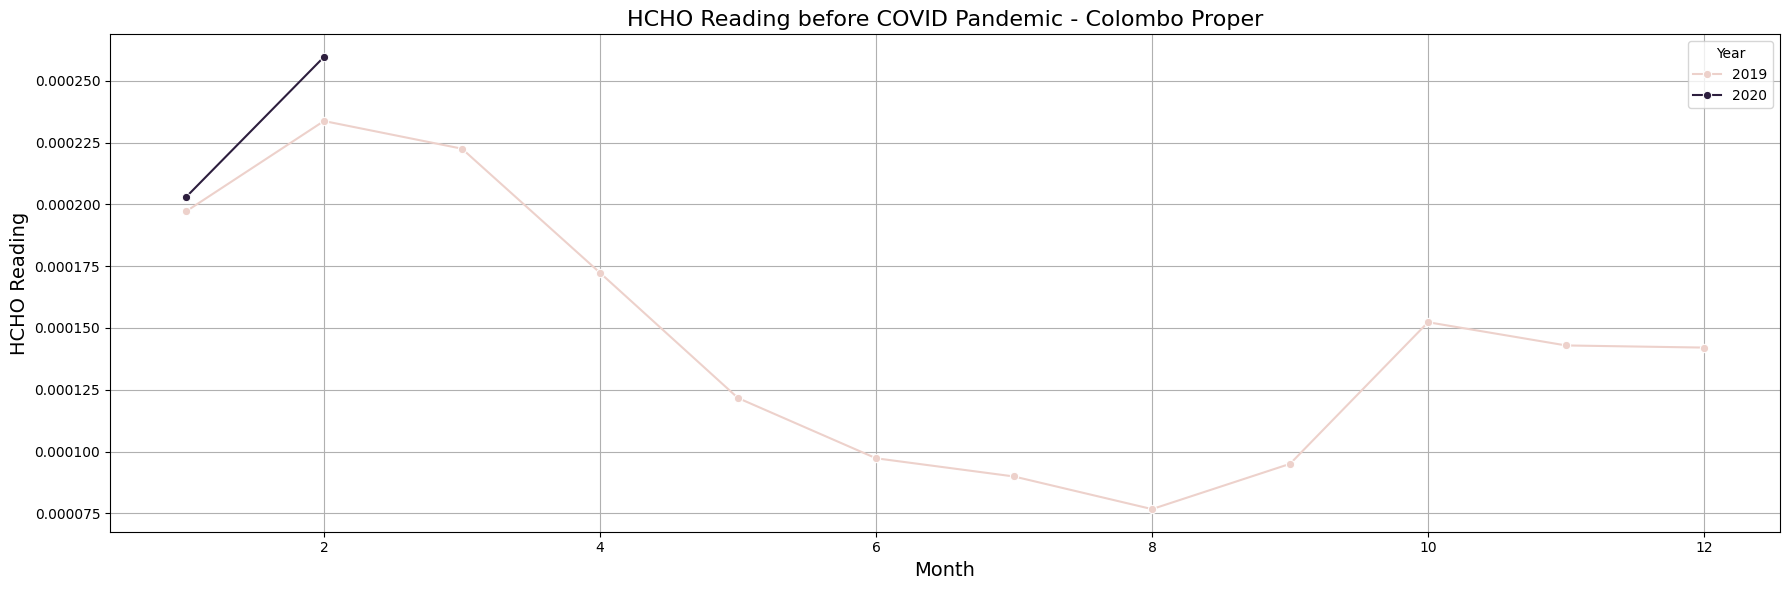

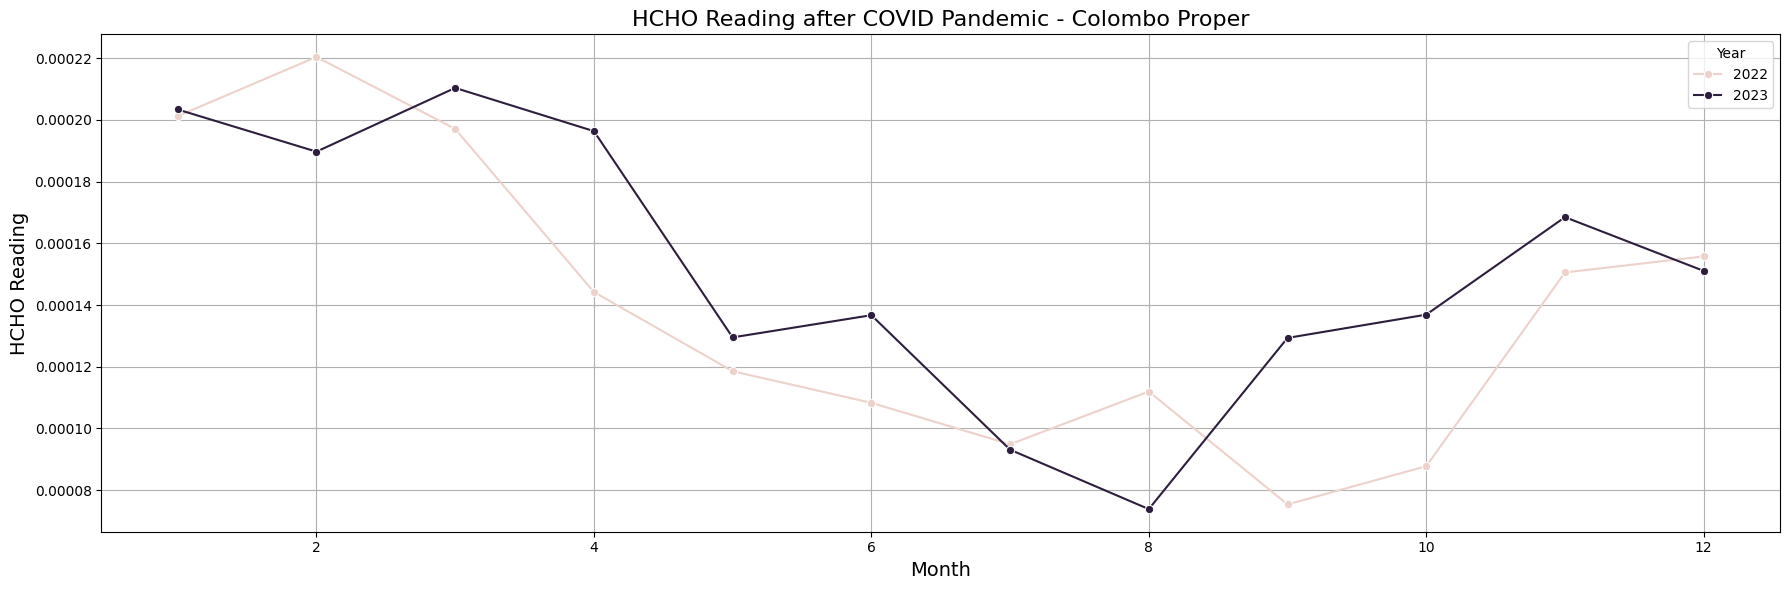

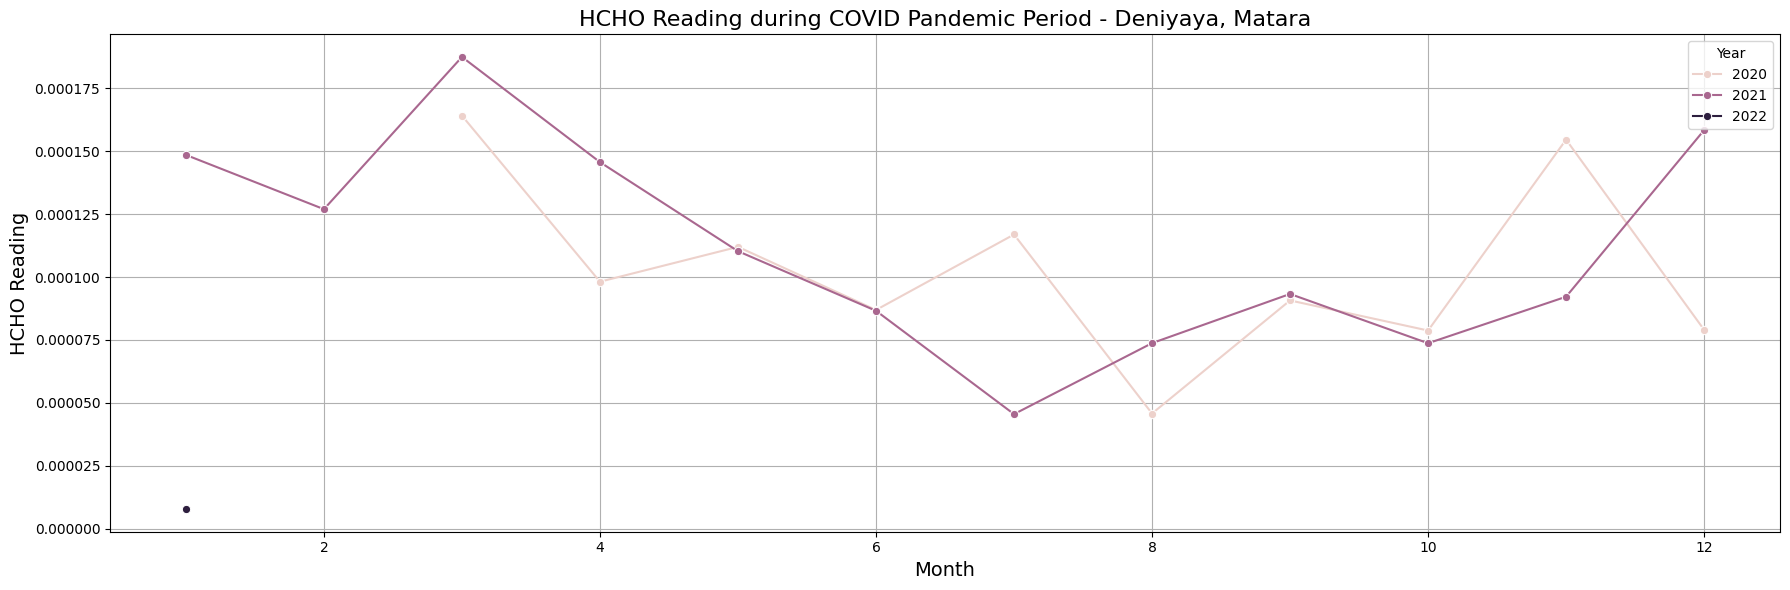

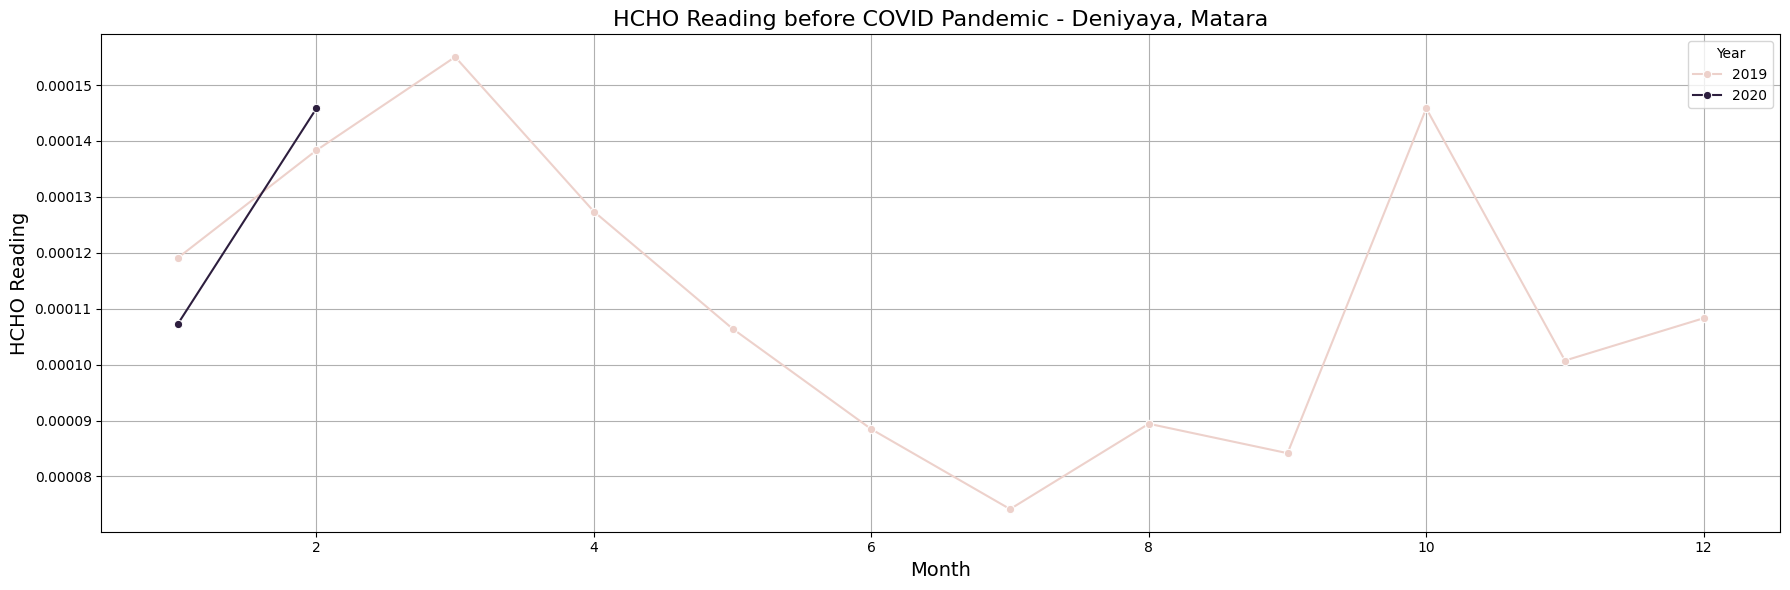

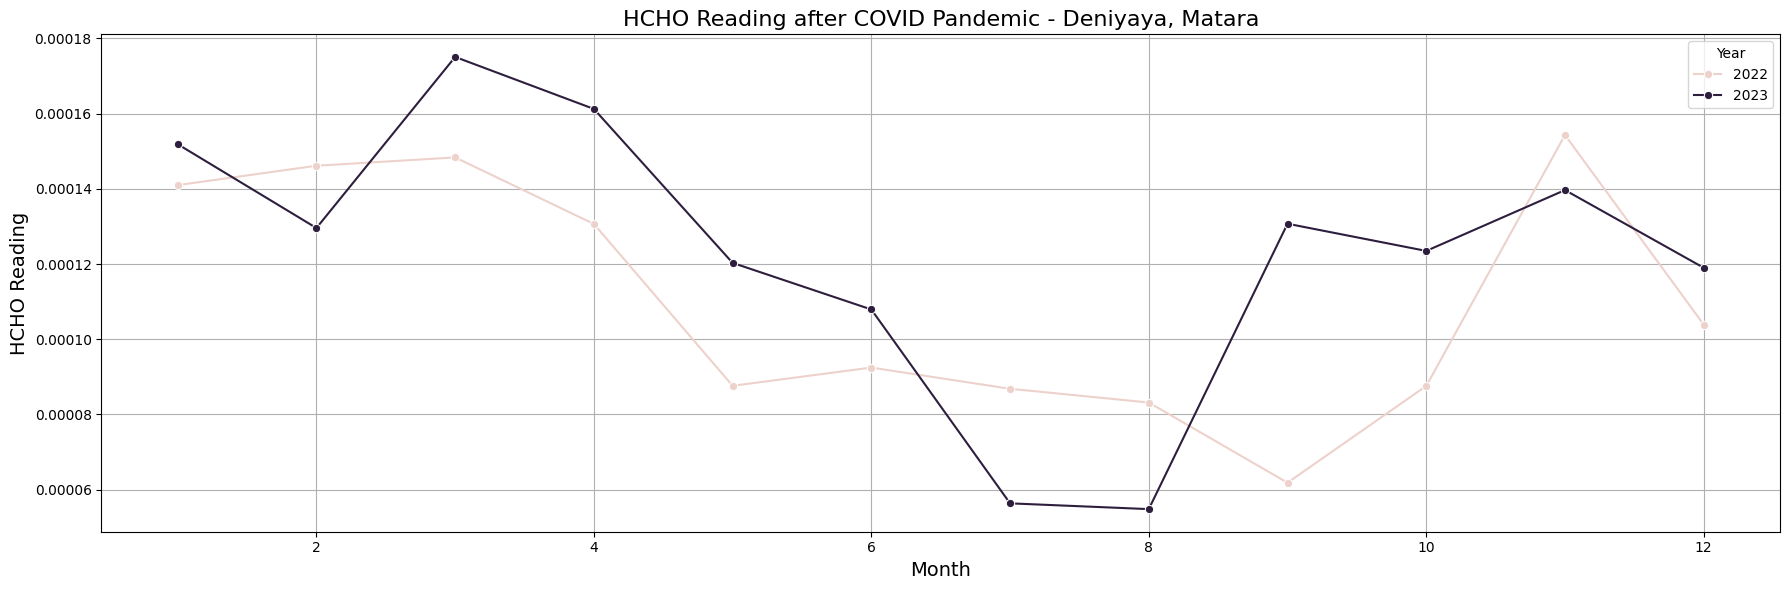

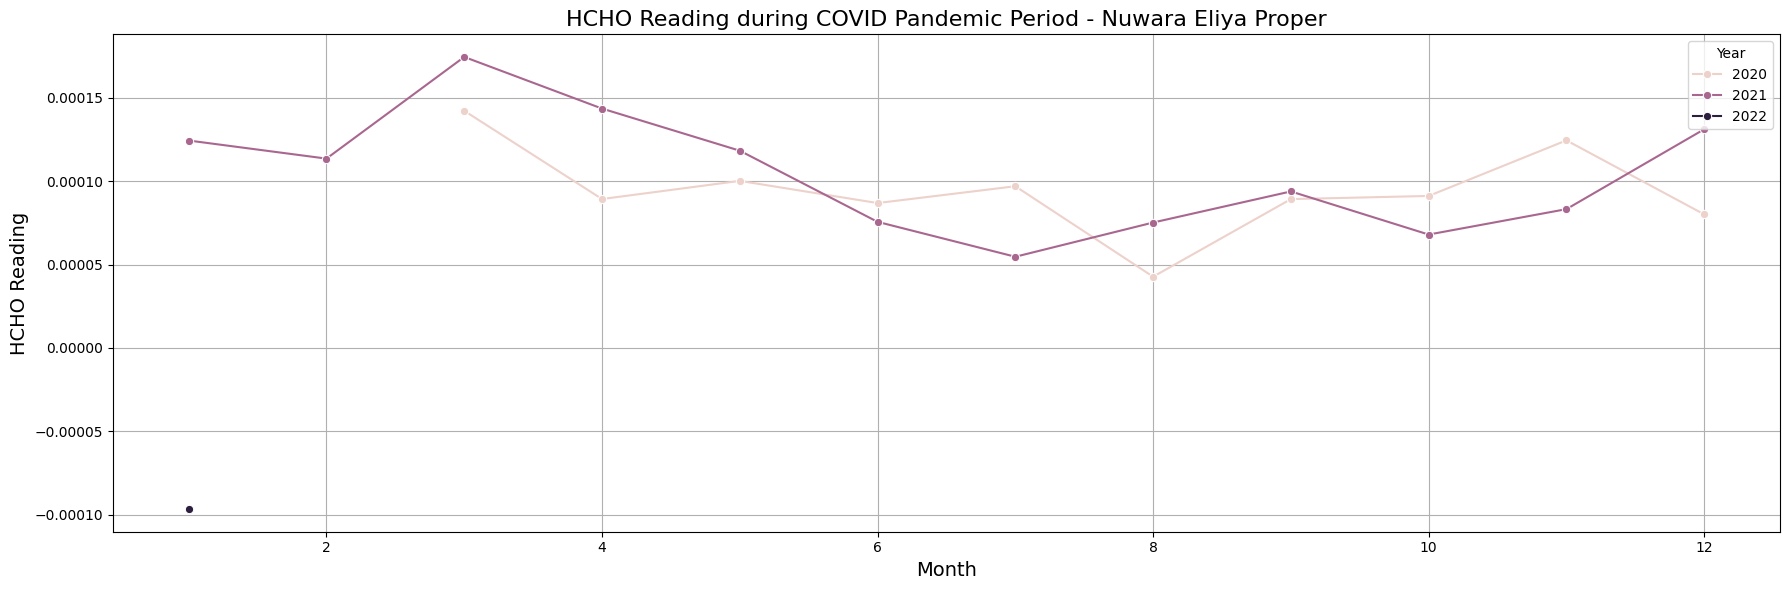

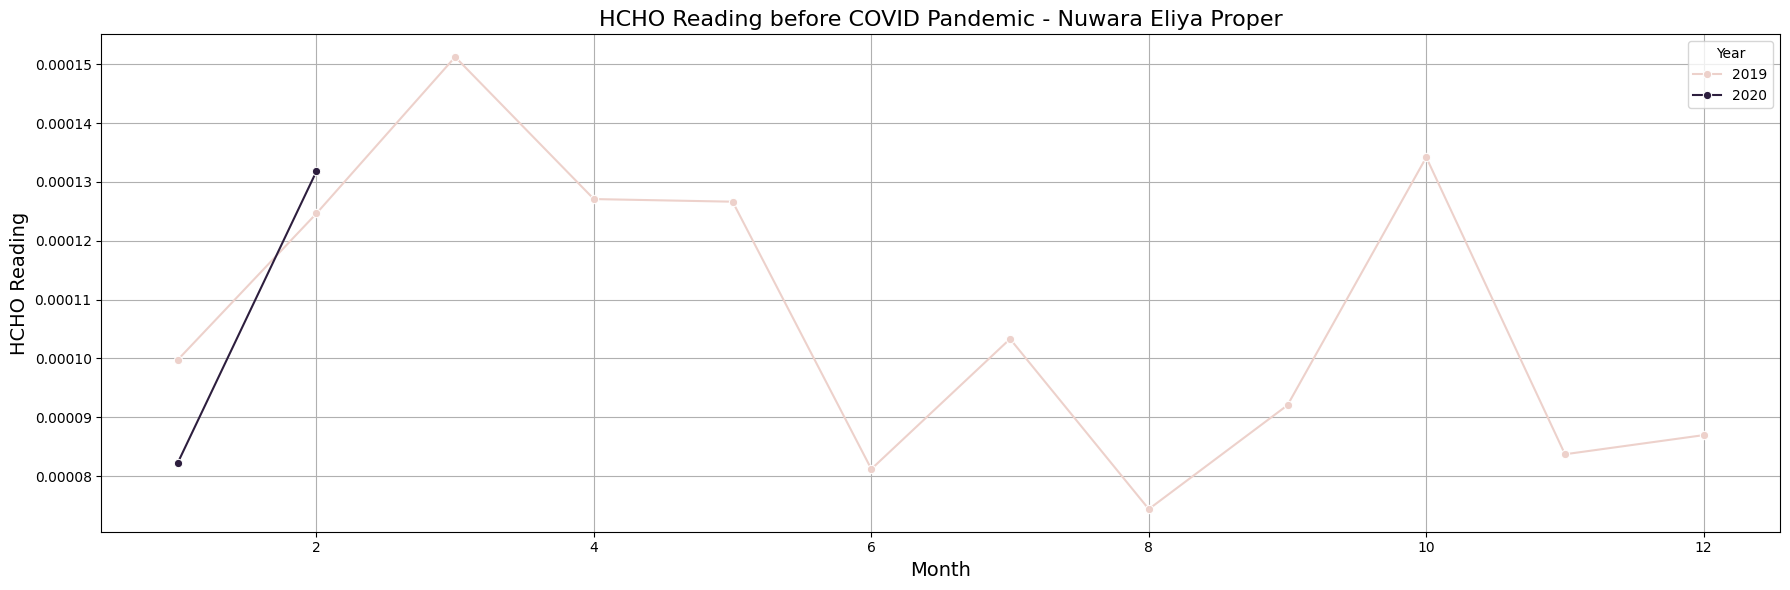

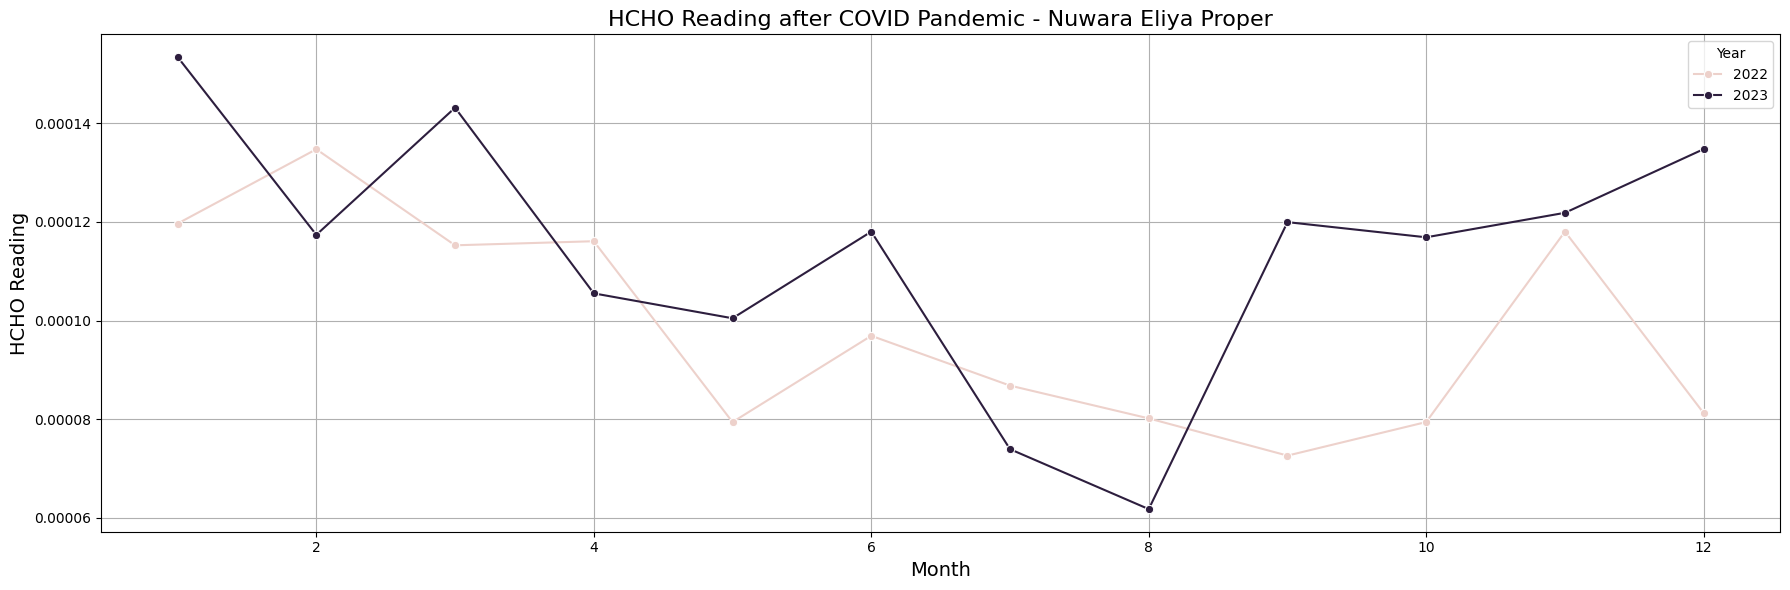

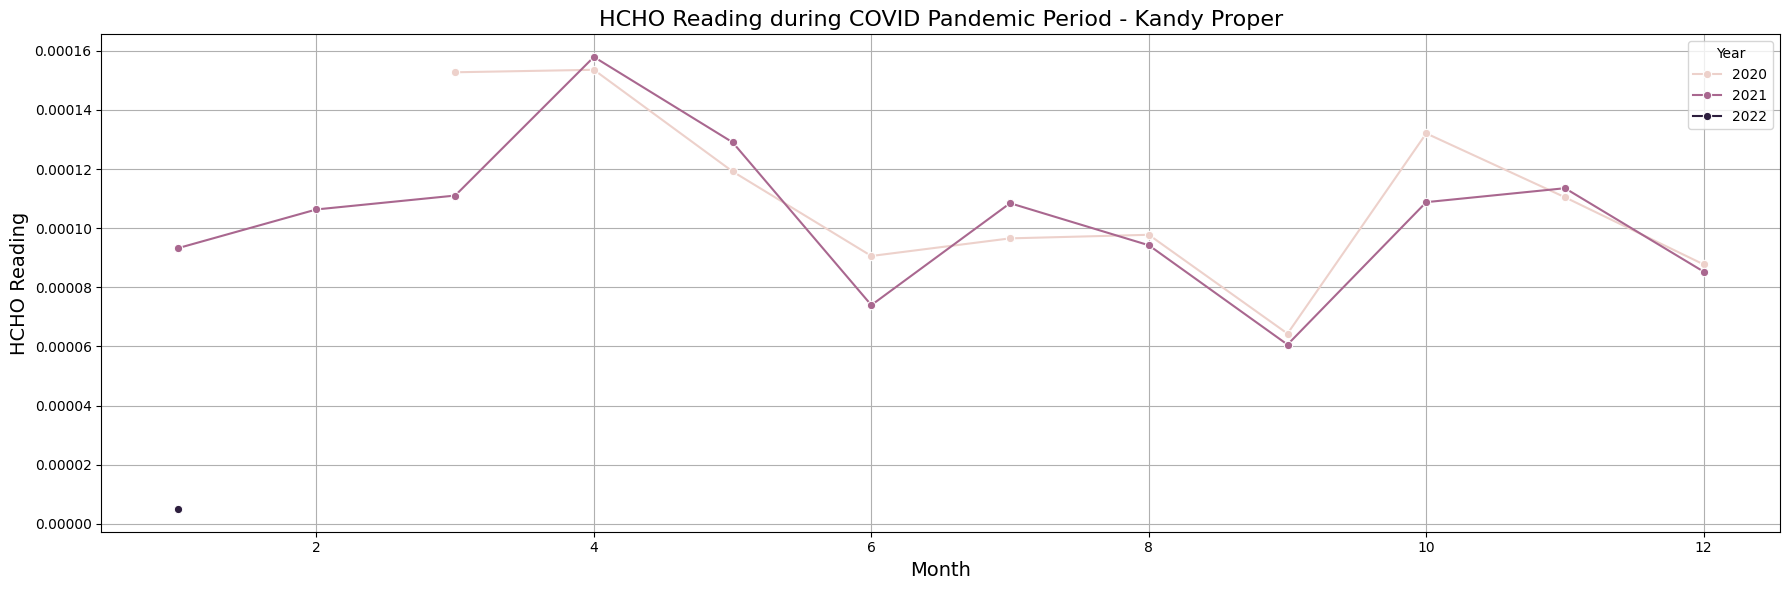

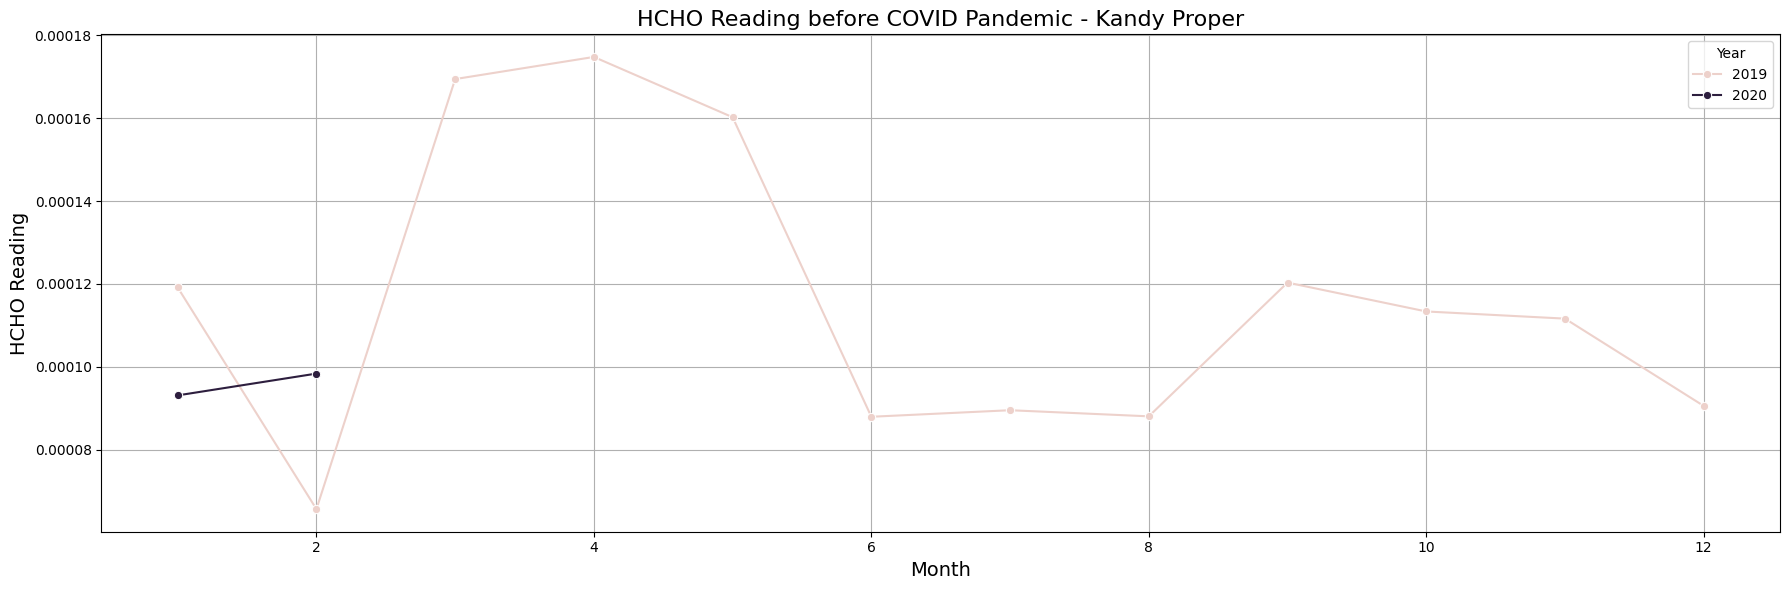

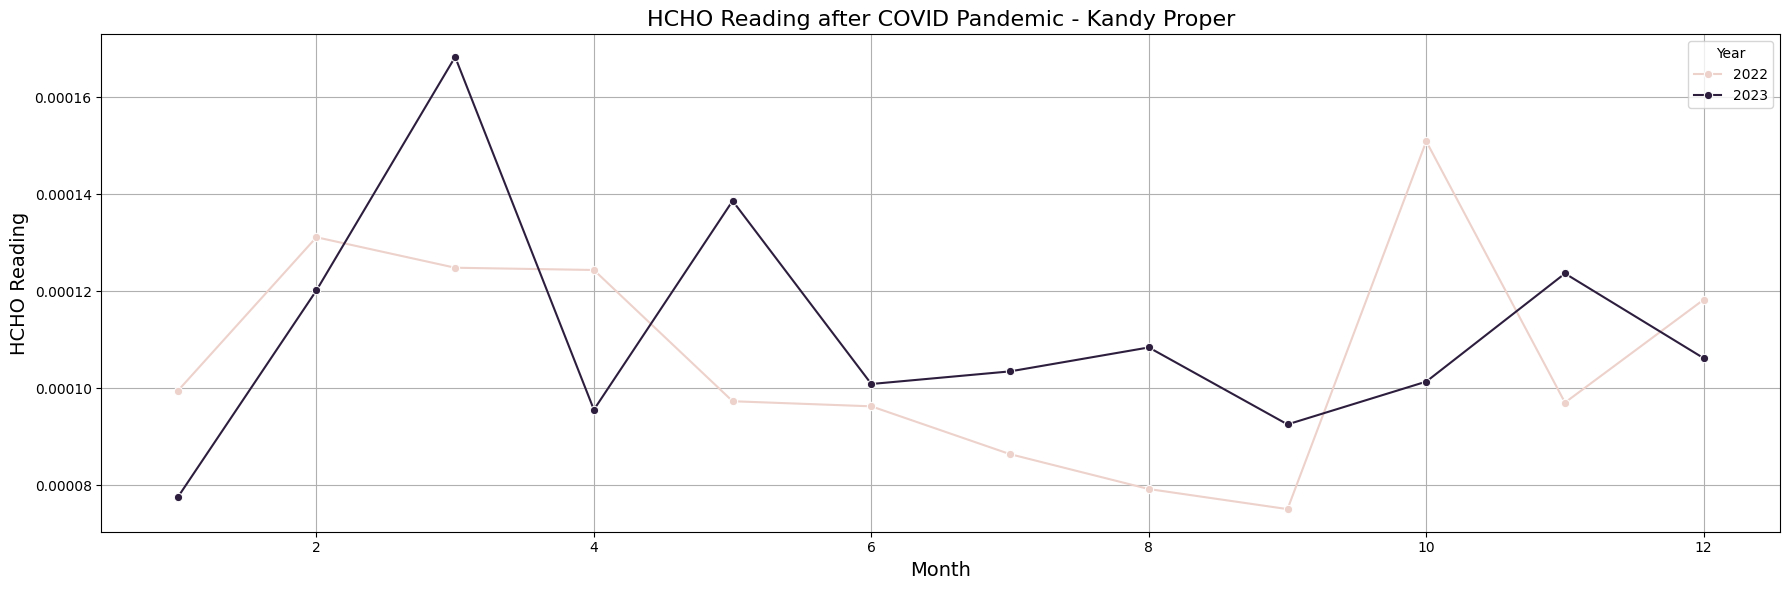

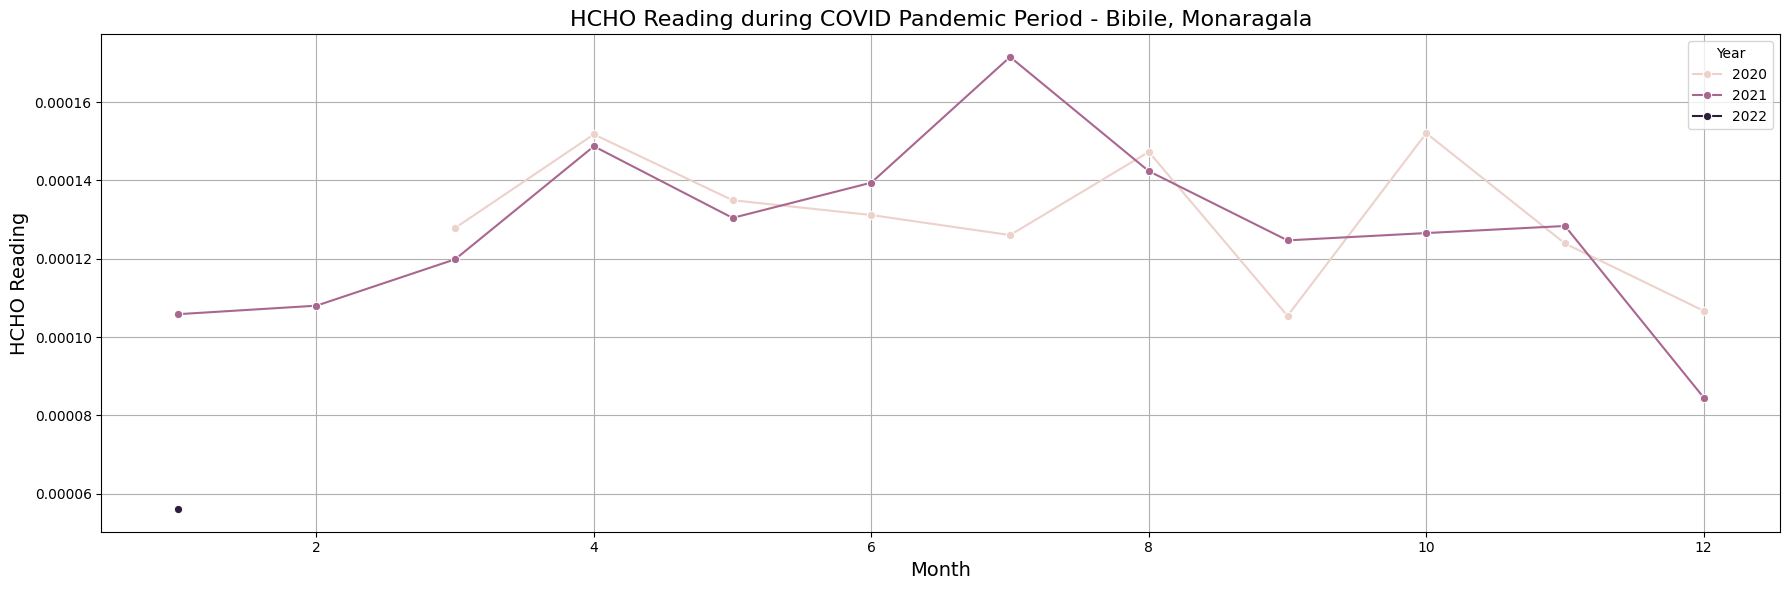

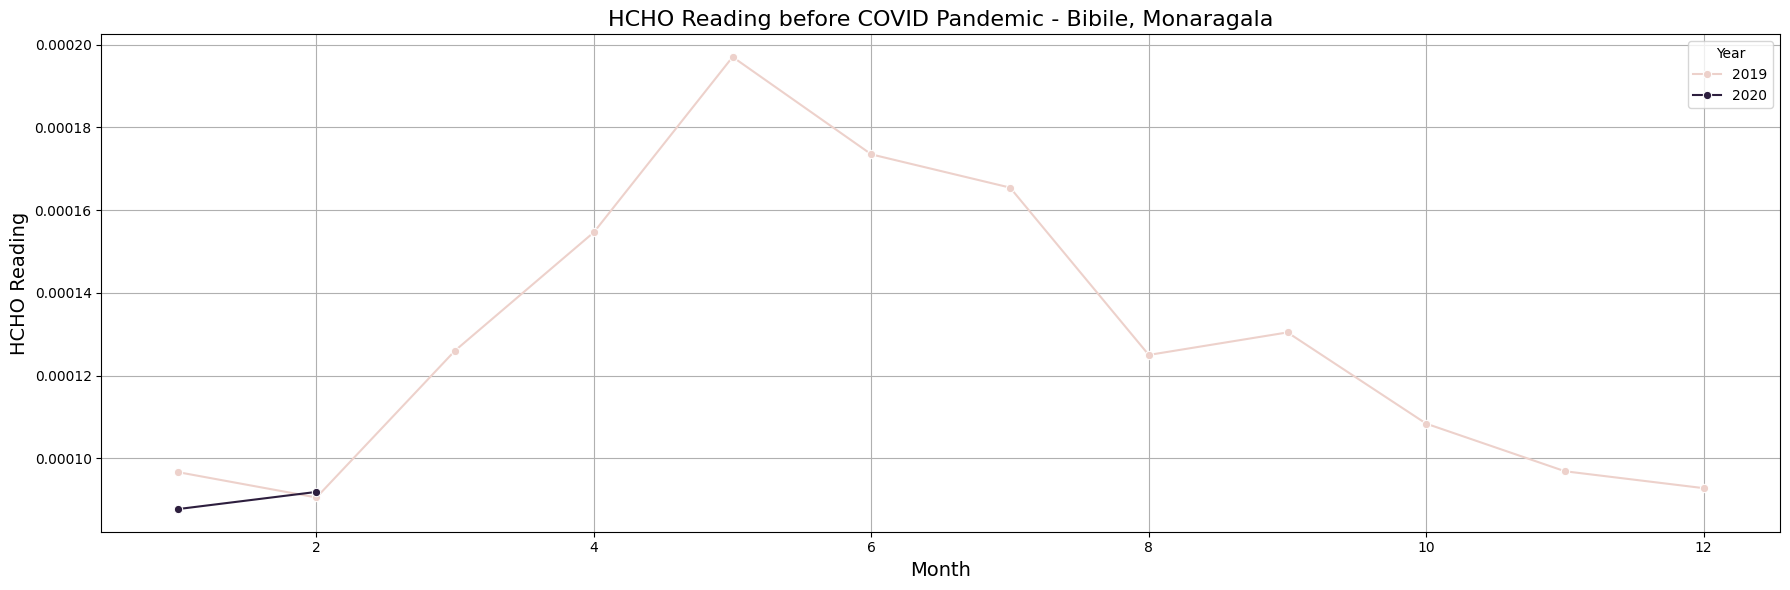

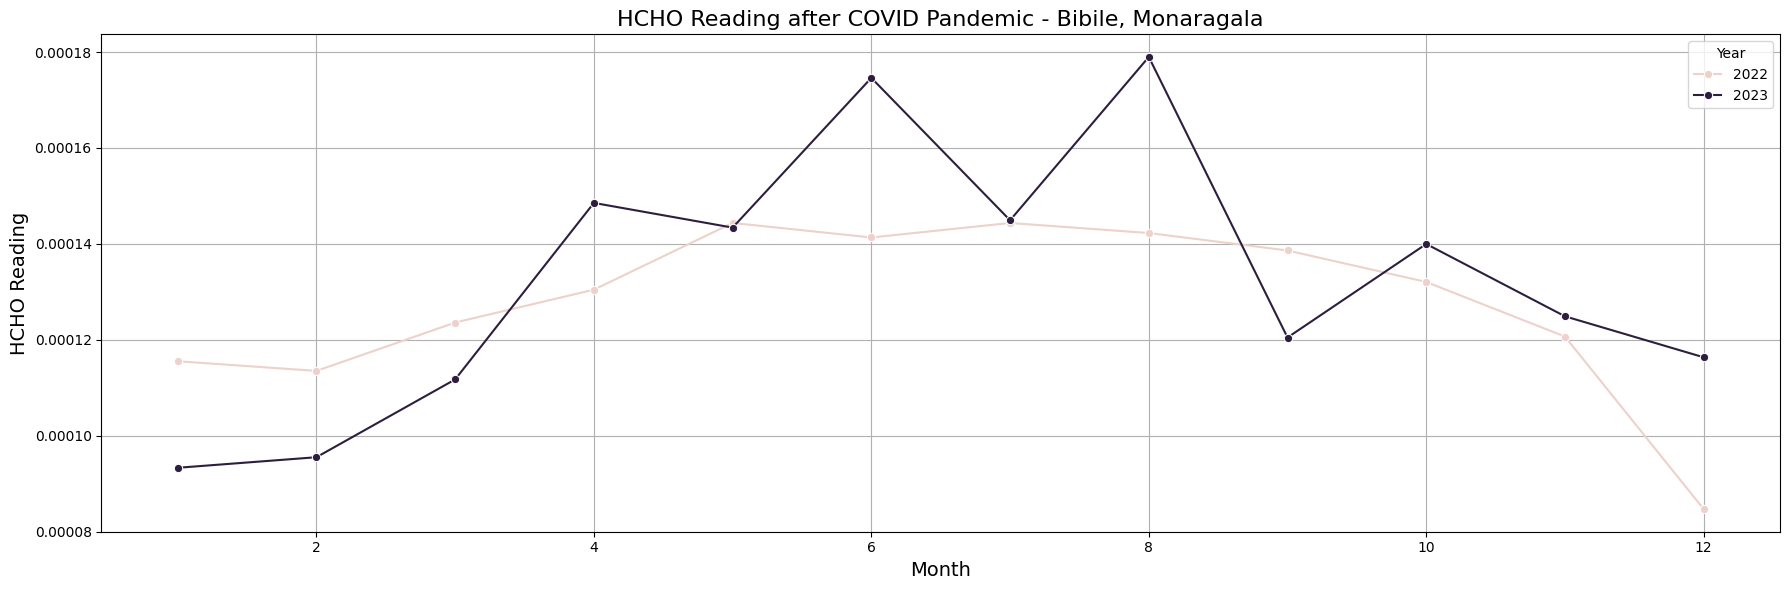

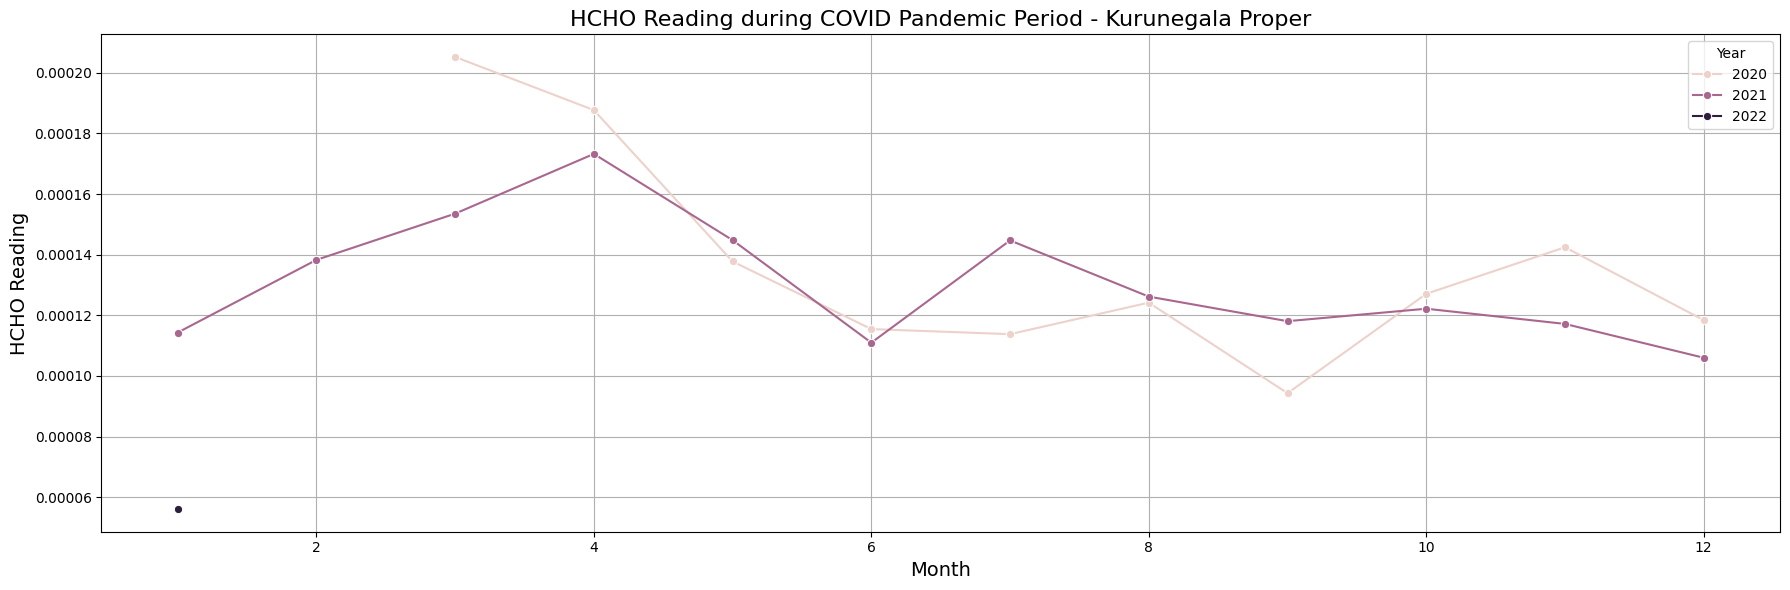

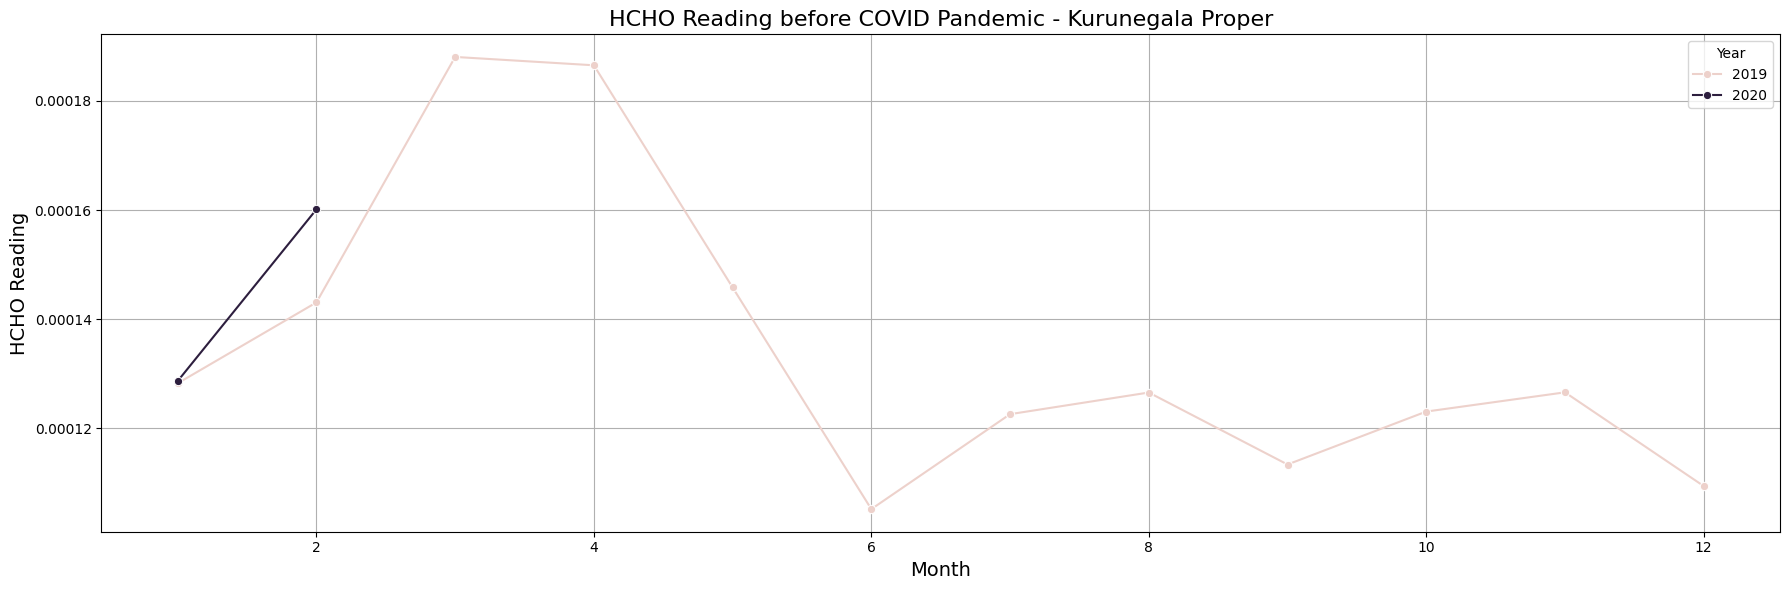

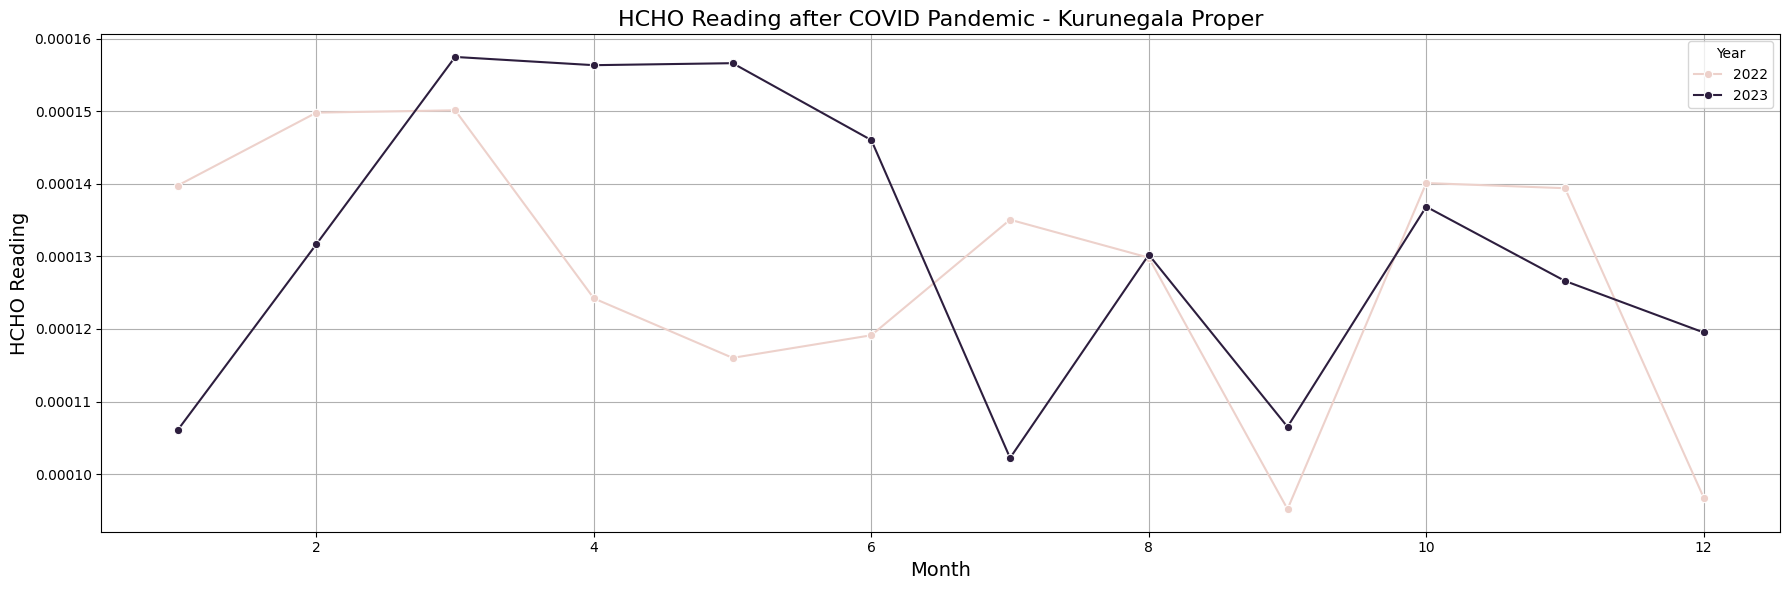

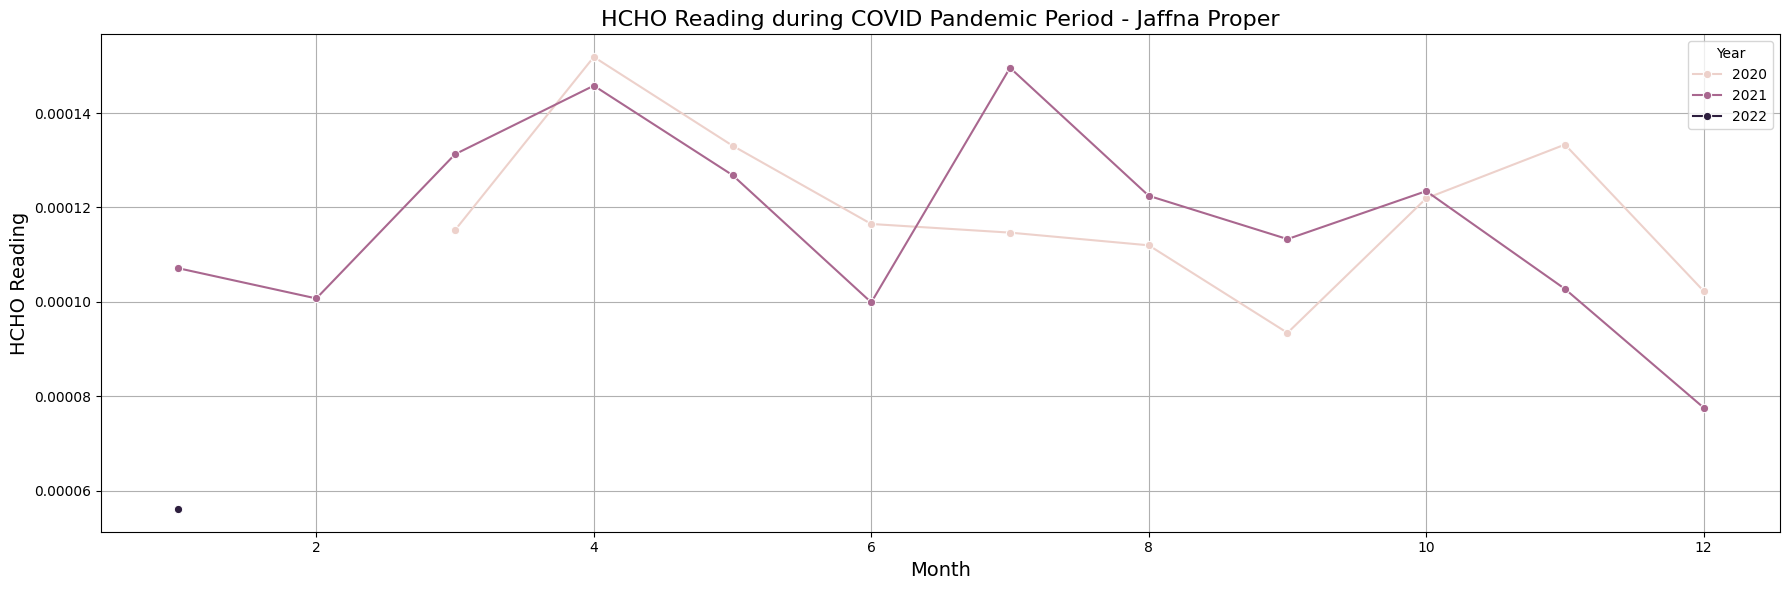

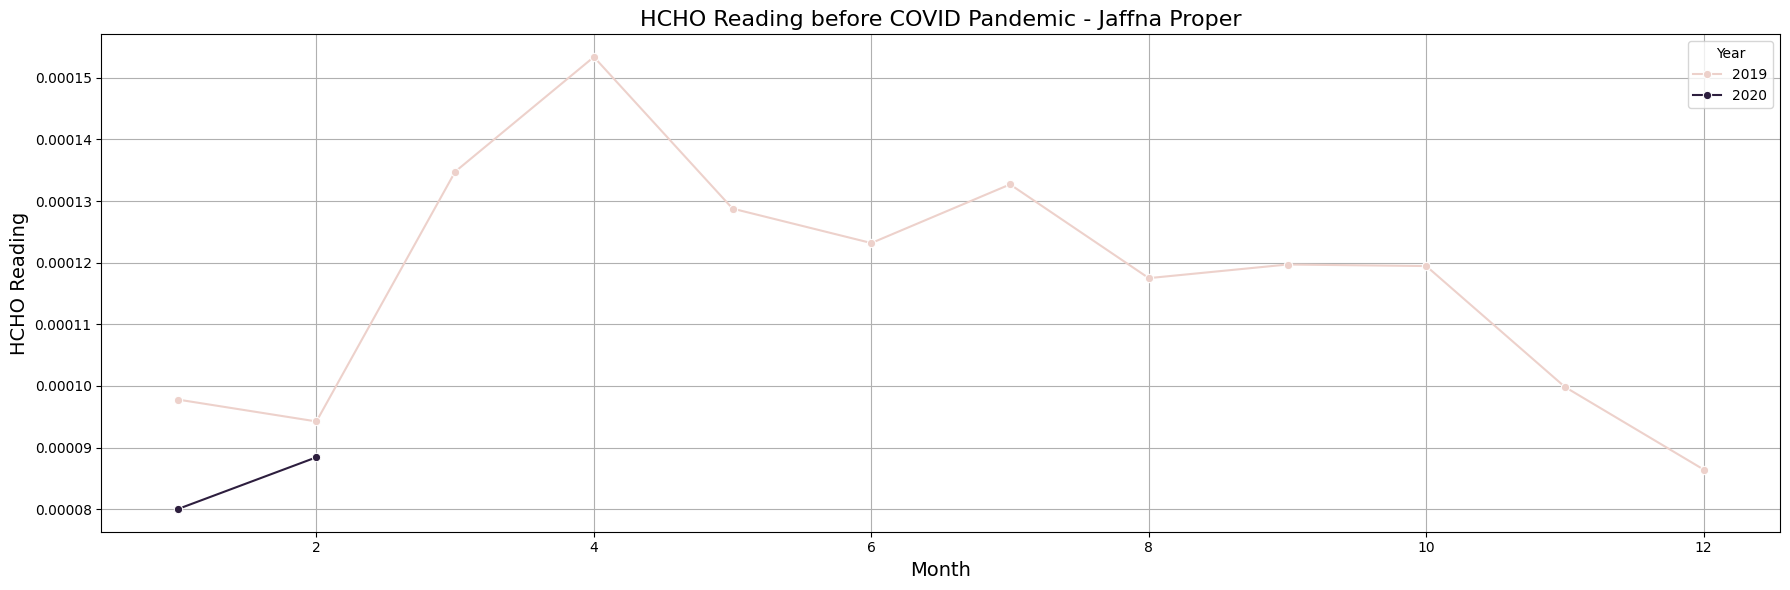

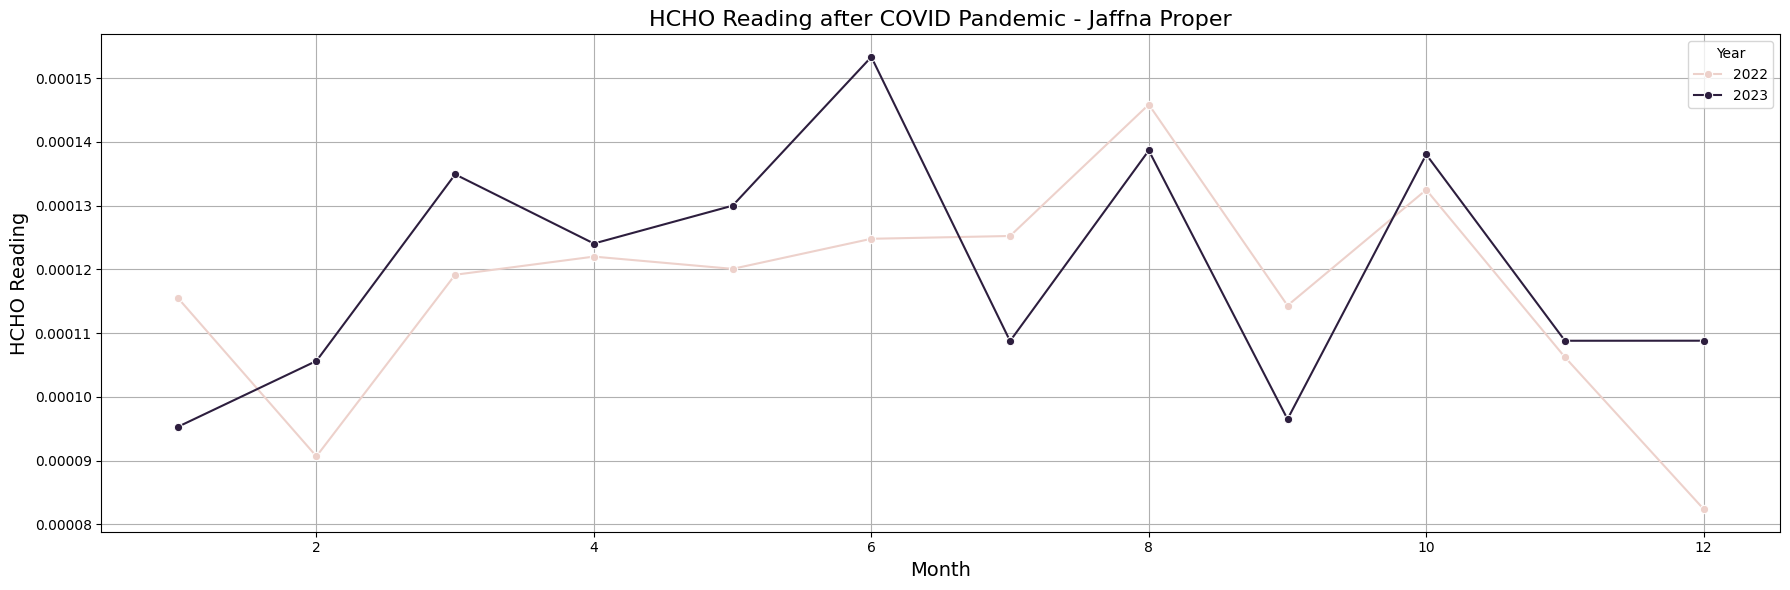

In [160]:
# Define date ranges for pandemic, pre-pandemic, and post-pandemic periods
covid_start_date = '2020-03-01' 
covid_end_date = '2022-01-01' 
pre_pandemic_end_date = '2020-02-29'
post_pandemic_start_date = '2022-01-02'

# Filter data for each period
covid_period = hcho_data[(hcho_data['Current Date'] >= covid_start_date) & (hcho_data['Current Date'] <= covid_end_date)]
pre_pandemic_period = hcho_data[hcho_data['Current Date'] <= pre_pandemic_end_date]
post_pandemic_period = hcho_data[hcho_data['Current Date'] >= post_pandemic_start_date]

# Get unique cities
cities = hcho_data['Location'].unique()

# Create a line plot for each city for each period
for city in cities:
    for data, title in zip([covid_period, pre_pandemic_period, post_pandemic_period],
                           ['HCHO Reading during COVID Pandemic Period',
                            'HCHO Reading before COVID Pandemic',
                            'HCHO Reading after COVID Pandemic']):
        city_data = data[data['Location'] == city]
        plt.figure(figsize=(18, 6))
        sns.lineplot(x='Month', y='HCHO Reading', data=city_data, marker='o', hue="Year", errorbar=None)
        plt.title(f'{title} - {city}', fontsize=16)
        plt.xlabel('Month', fontsize=14)
        plt.ylabel('HCHO Reading', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


### GAS EMISSIONS & LONG-TERM TRENDS

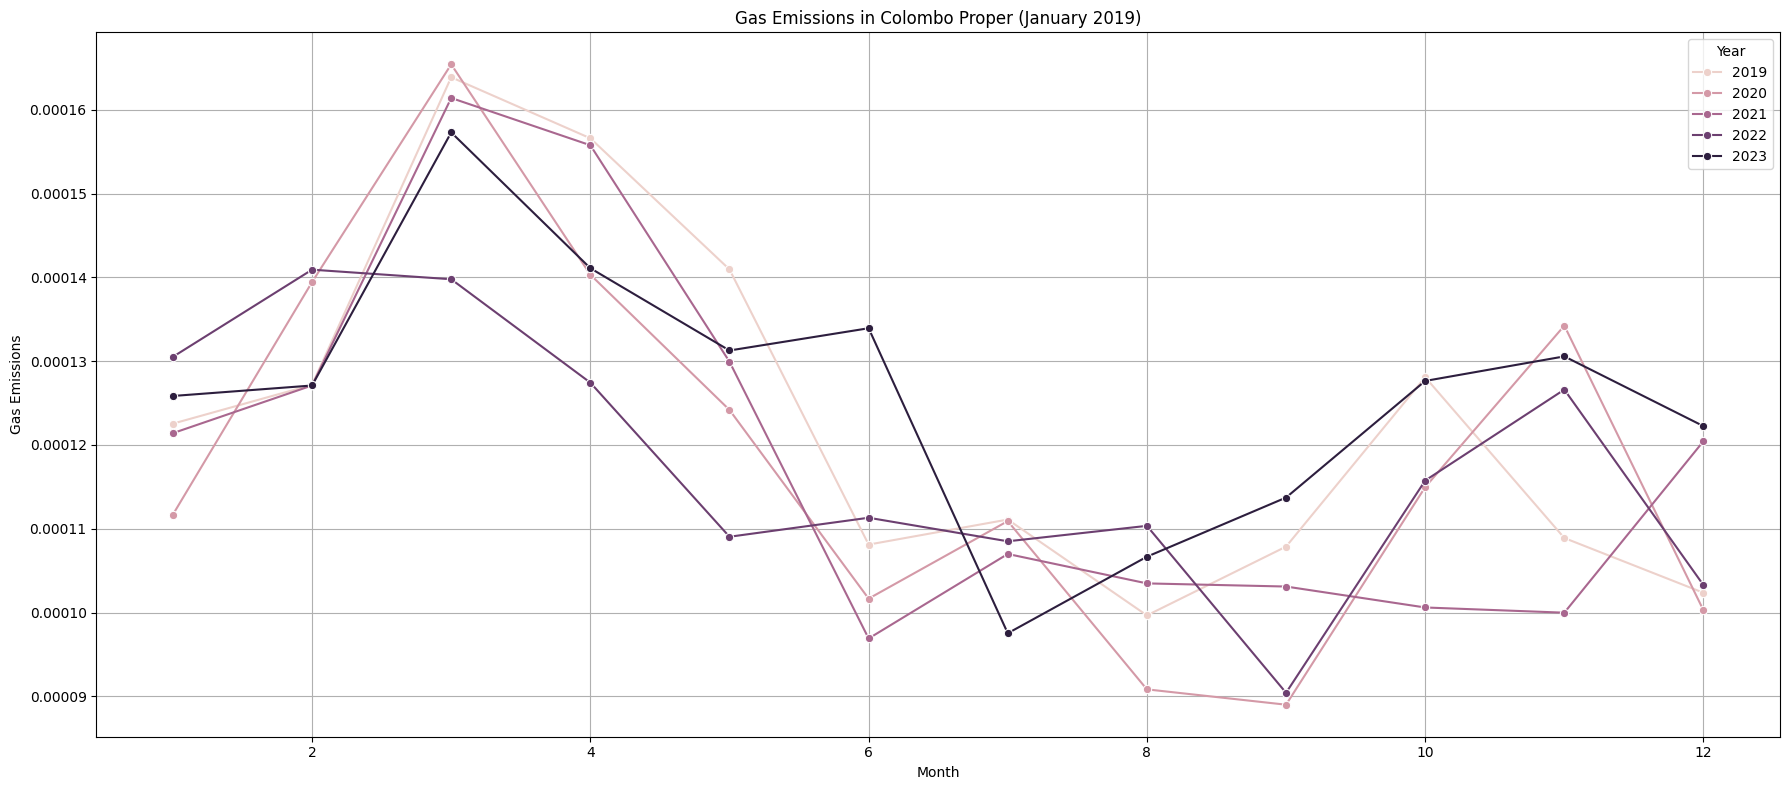

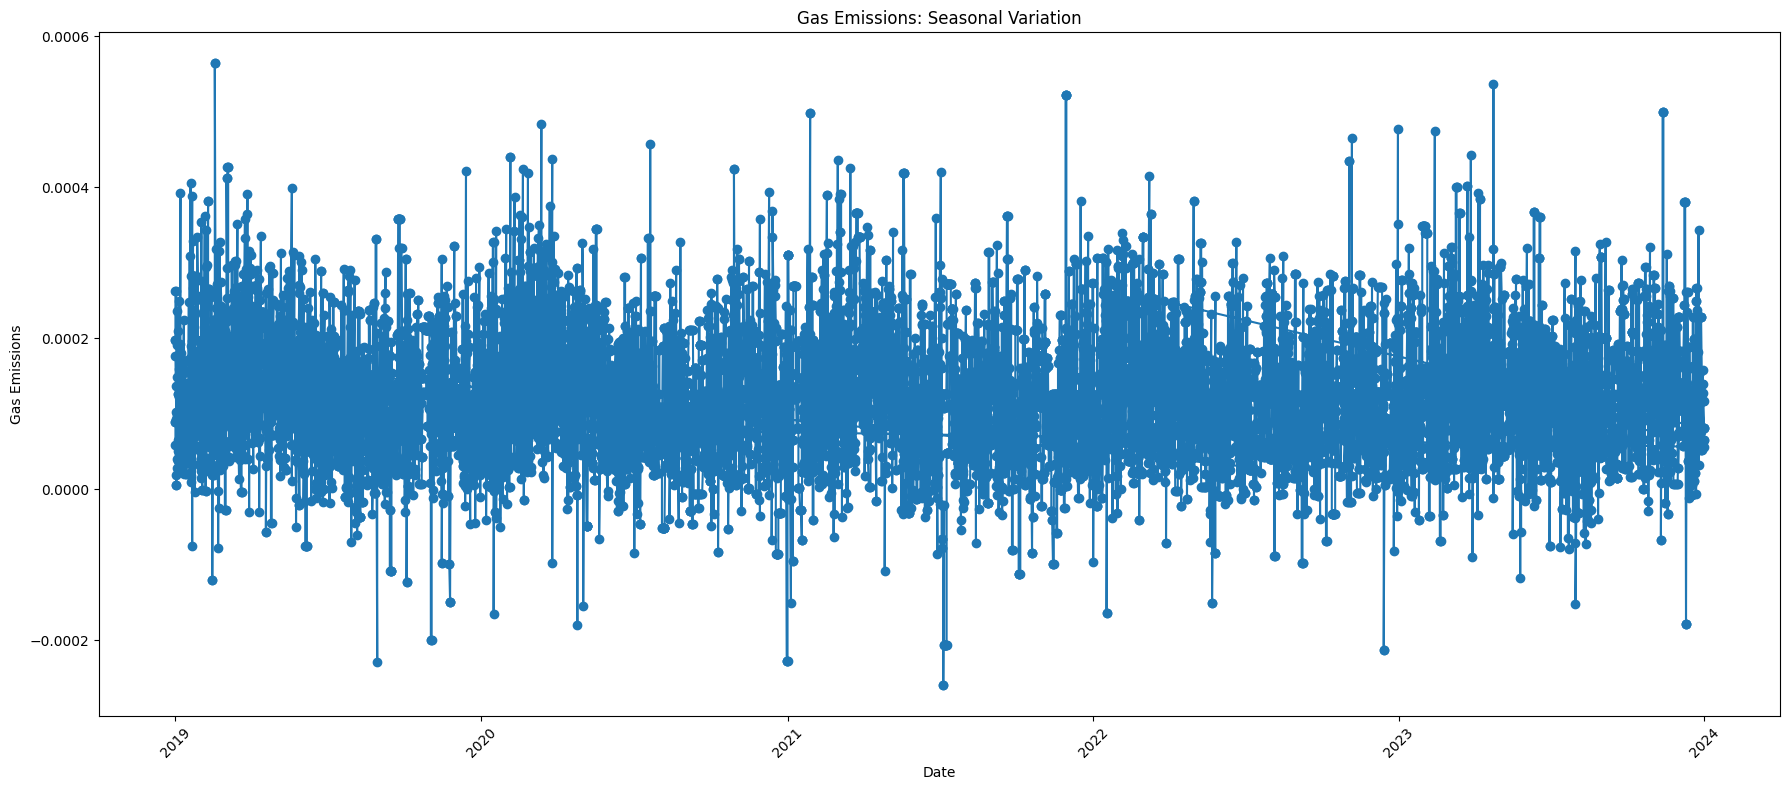

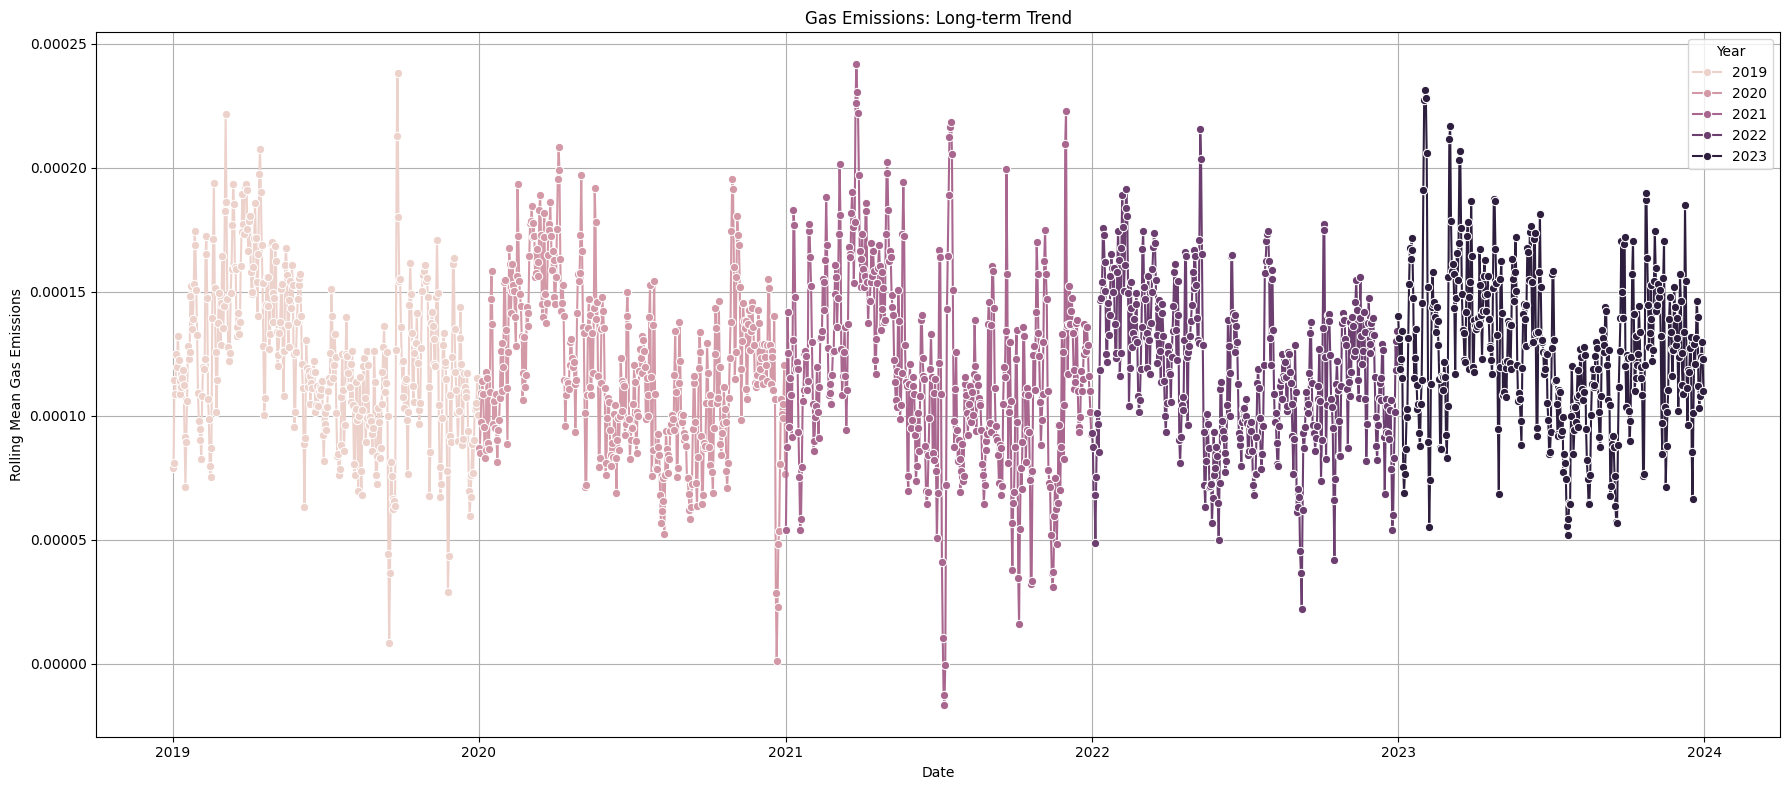

In [161]:
# Convert HCHO Reading to float
hcho_data['HCHO Reading'] = pd.to_numeric(hcho_data['HCHO Reading'], errors='coerce')

# Convert date columns to datetime
hcho_data['Current Date'] = pd.to_datetime(hcho_data['Current Date'])
hcho_data['Next Date'] = pd.to_datetime(hcho_data['Next Date'])


# Plot gas emissions over time for Colombo Proper
plt.figure(figsize=(18, 8)) 
sns.lineplot(x='Month', y='HCHO Reading', data=hcho_data, marker='o', hue="Year", errorbar=None)
plt.title('Gas Emissions in Colombo Proper (January 2019)')
plt.xlabel('Month')
plt.ylabel('Gas Emissions')
plt.grid(True)
plt.tight_layout()

# Identify seasonal variations
plt.figure(figsize=(18, 8)) 
plt.plot(hcho_data['Current Date'], hcho_data['HCHO Reading'], marker='o', label='Colombo Proper')
plt.title('Gas Emissions: Seasonal Variation')
plt.xlabel('Date')
plt.ylabel('Gas Emissions')
plt.xticks(rotation=45)
plt.tight_layout()

# Identify long-term trends (example: using rolling mean)
plt.figure(figsize=(18, 8)) 
hcho_data['Rolling_Mean'] = hcho_data['HCHO Reading'].rolling(window=7).mean()
sns.lineplot(x='Current Date', y='Rolling_Mean', data=hcho_data, marker='o', hue="Year", errorbar=None)
plt.title('Gas Emissions: Long-term Trend')
plt.xlabel('Date')
plt.ylabel('Rolling Mean Gas Emissions')
plt.grid(True)
plt.tight_layout()

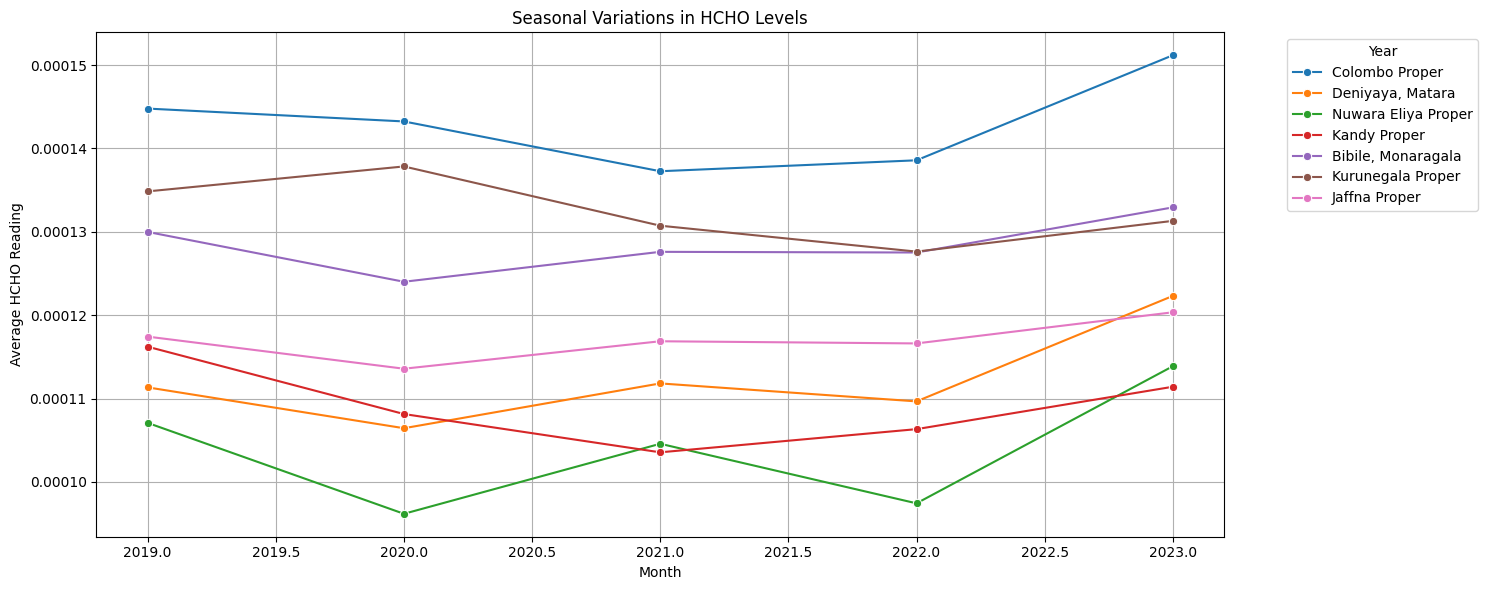

In [162]:
# Plotting seasonal variations
plt.figure(figsize=(15, 6))
sns.lineplot(x="Year", y="HCHO Reading", hue="Location", data=hcho_data, marker='o', errorbar=None)
plt.title('Seasonal Variations in HCHO Levels')
plt.xlabel('Month')
plt.ylabel('Average HCHO Reading')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### CITY BY CITY CHANGES

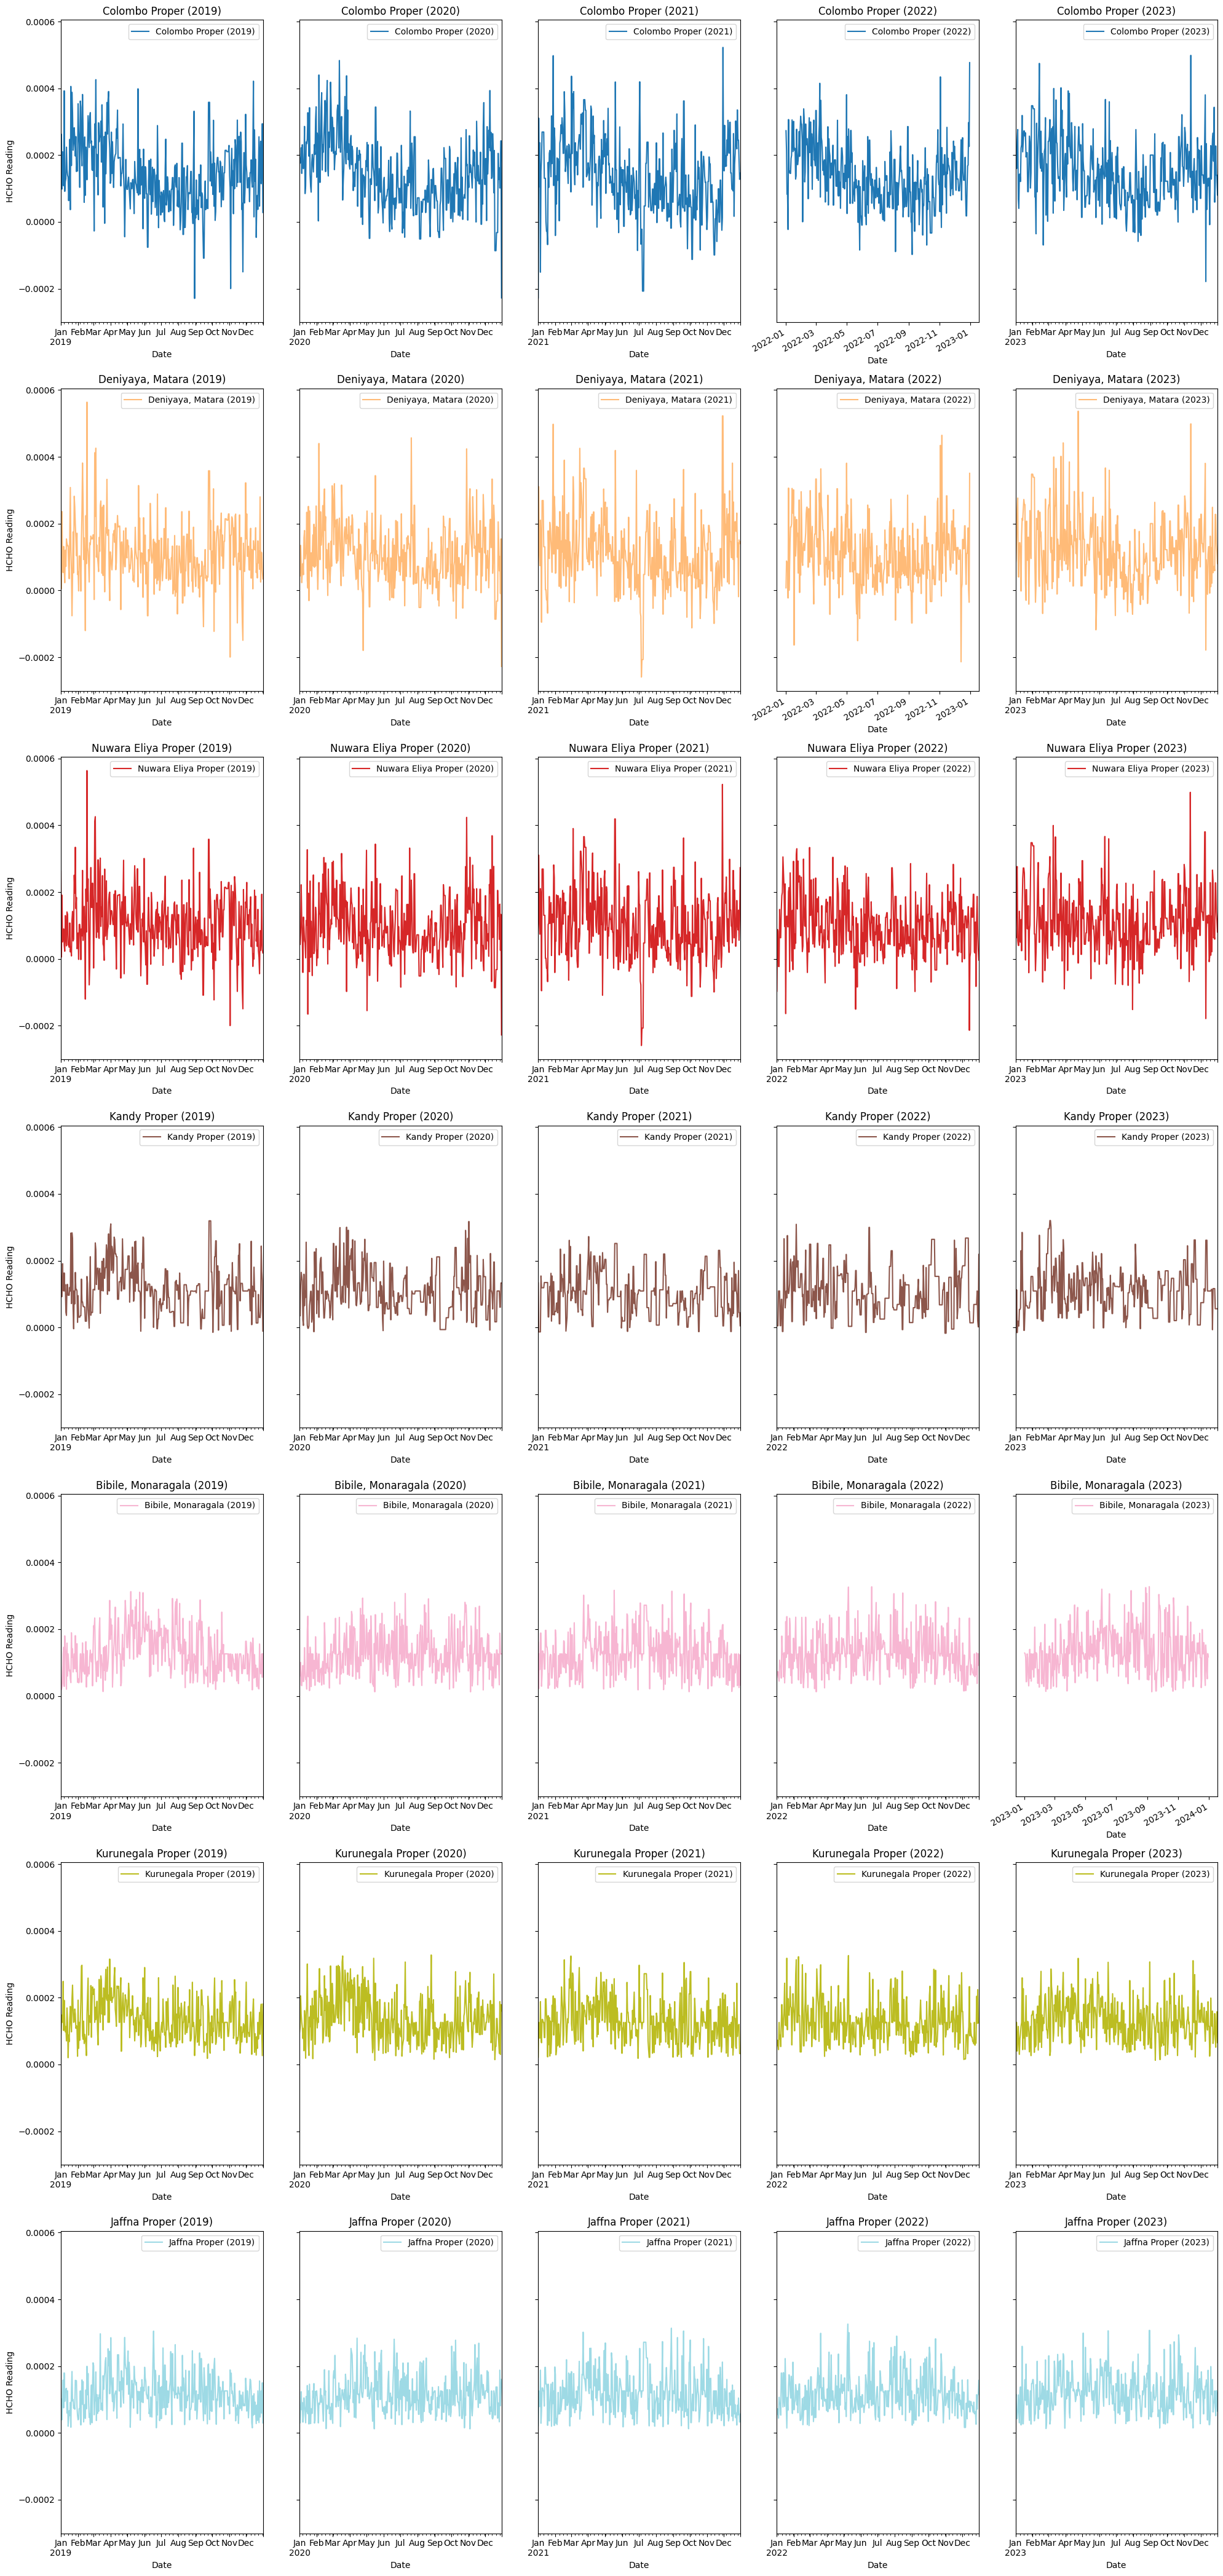

In [163]:
# Assuming you have your data in a pandas DataFrame named 'hcho_data'
locations = hcho_data['Location'].unique()
years = hcho_data['Current Date'].dt.year.unique()

# Create a colormap and assign a color to each location
cmap = cm.get_cmap('tab20', len(locations))
colors = {loc: cmap(i) for i, loc in enumerate(locations)}

# Create a figure with subplots for each location and year
fig, axes = plt.subplots(nrows=len(locations), ncols=len(years), figsize=(20, 6 * len(locations)), sharey=True)

# Iterate over locations and years, and plot each one in a separate subplot
for i, location in enumerate(locations):
    for j, year in enumerate(years):
        group = hcho_data[(hcho_data['Location'] == location) & (hcho_data['Current Date'].dt.year == year)]
        ax = axes[i, j] if len(locations) > 1 else axes
        group.set_index('Current Date')['HCHO Reading'].plot(ax=ax, label=f'{location} ({year})', color=colors[location])
        ax.set_title(f'{location} ({year})')
        ax.set_xlabel('Date')
        if j == 0:
            ax.set_ylabel('HCHO Reading')
        ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

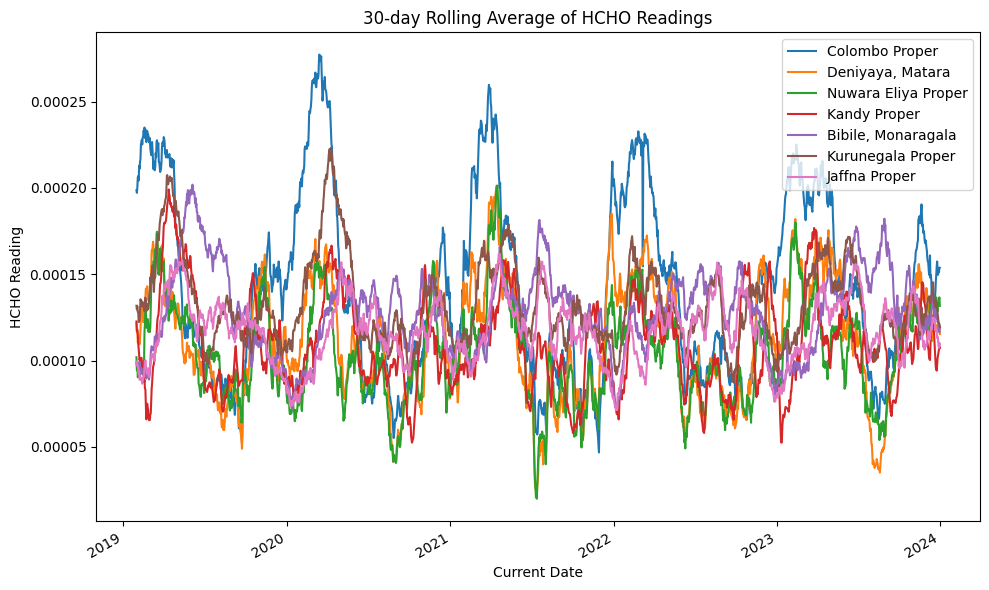

In [164]:
# 2. Comparison Across Cities
# Plotting the rolling average to compare trends
rolling_window = 30  # 30-day rolling window
fig, ax = plt.subplots(figsize=(10, 6))
for location in hcho_data['Location'].unique():
    hcho_data_location = hcho_data[hcho_data['Location'] == location]
    hcho_data_location.set_index('Current Date', inplace=True)
    hcho_data_location['HCHO Reading'].rolling(window=rolling_window).mean().plot(ax=ax, label=location)
ax.set_title(f'{rolling_window}-day Rolling Average of HCHO Readings')
ax.set_ylabel('HCHO Reading')
ax.legend()
plt.tight_layout()
plt.show()

### SEASONAL VARIATIONS, RESIDUALS & TRENDS

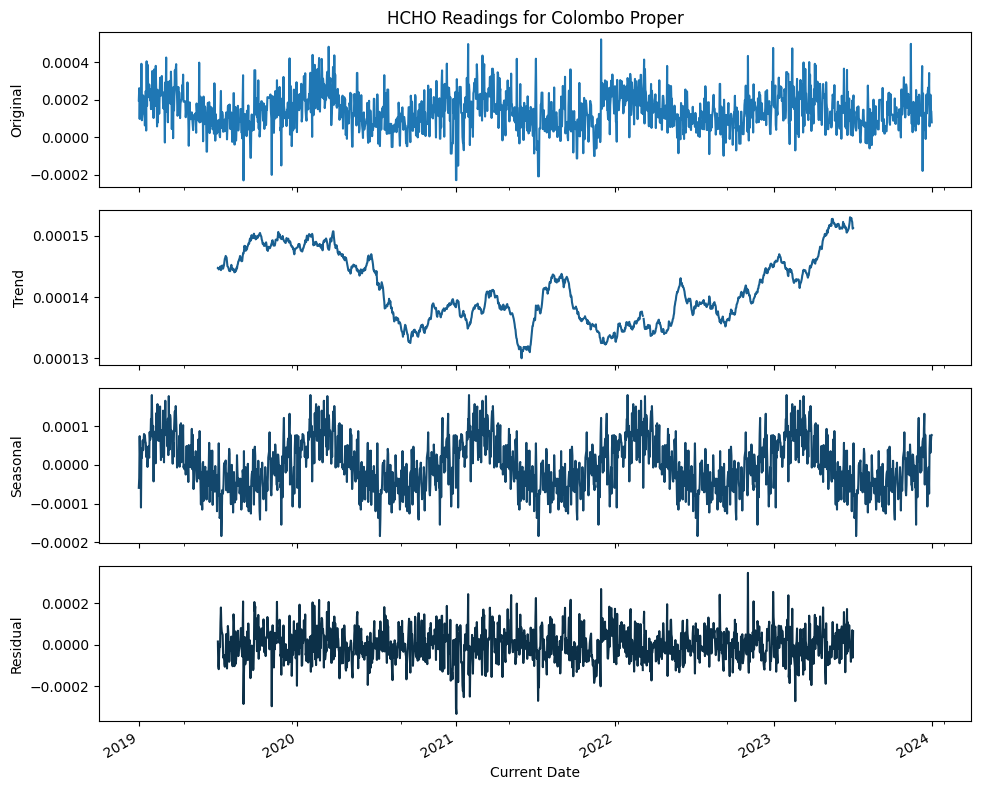

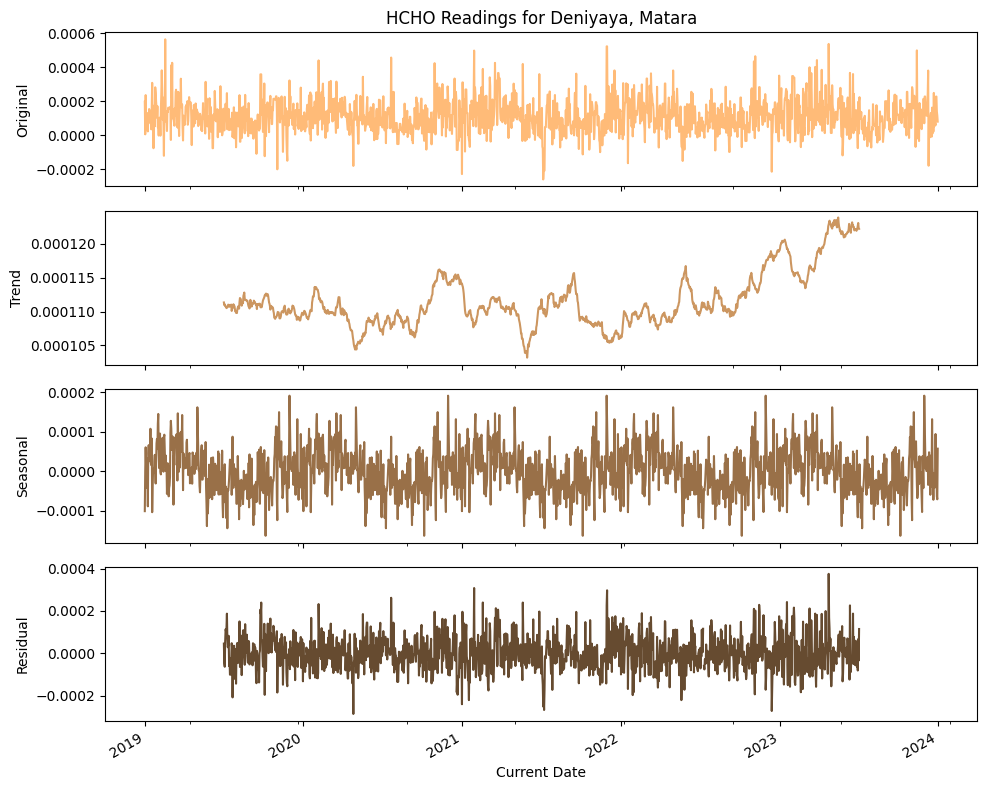

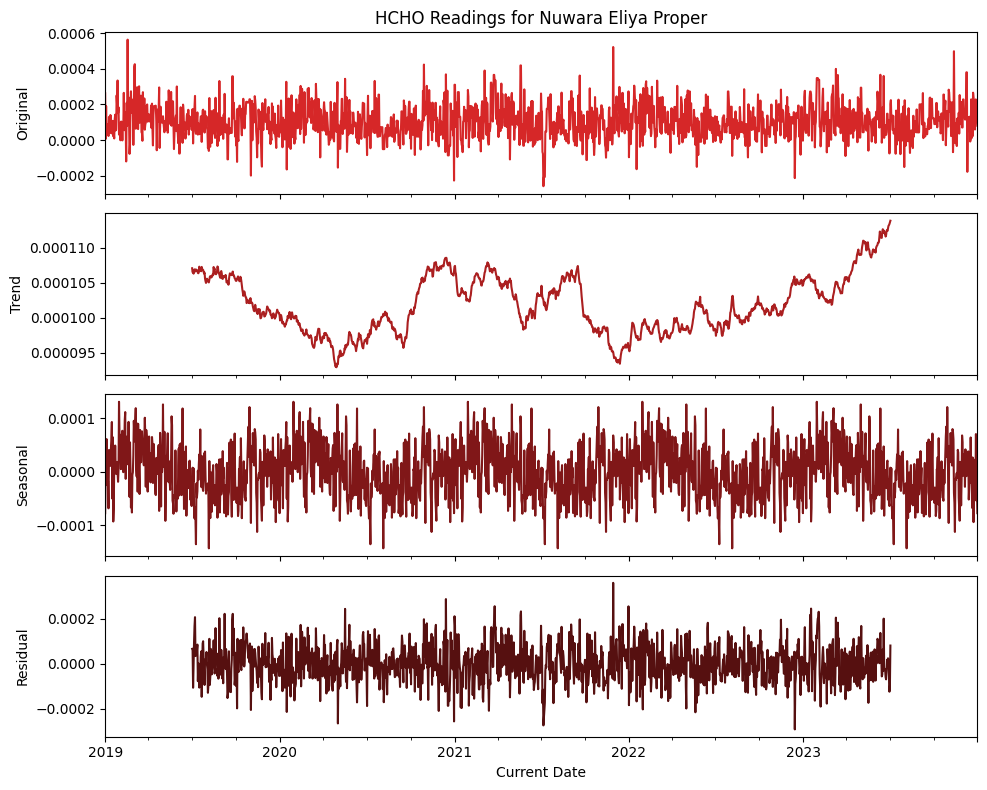

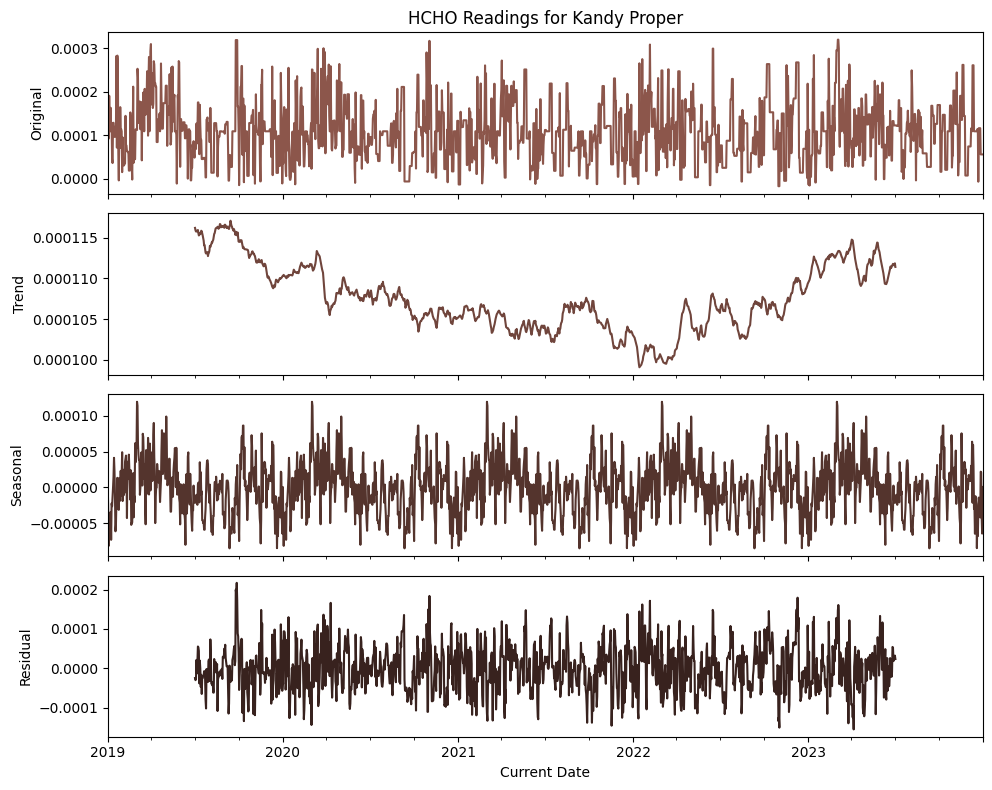

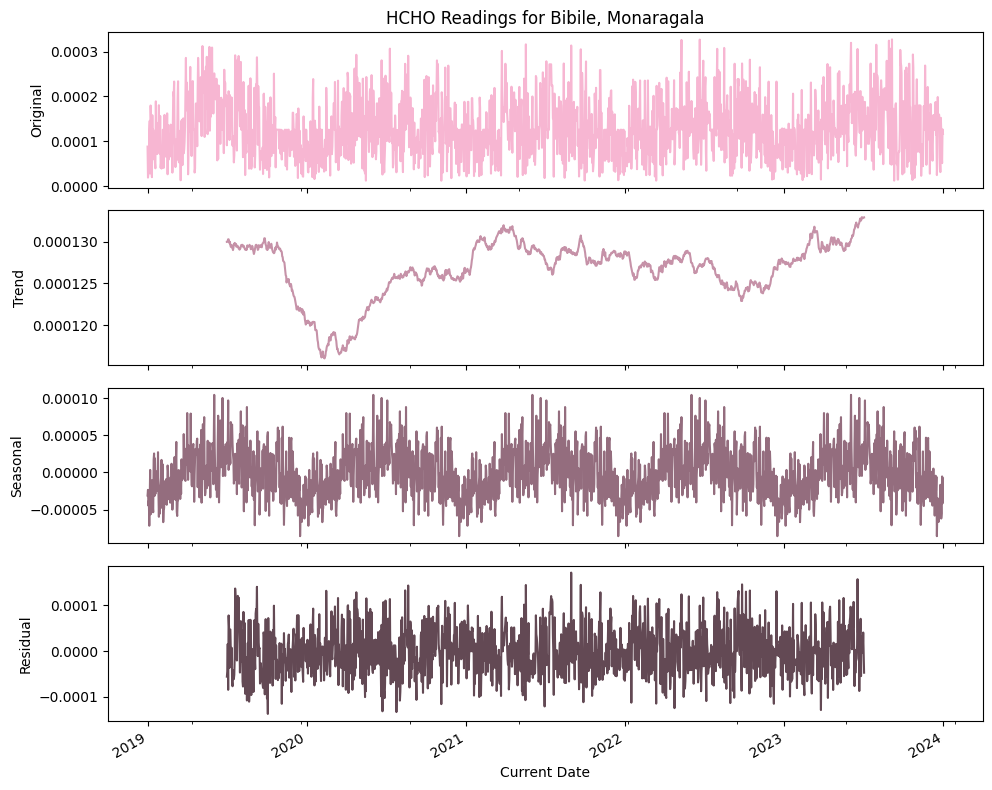

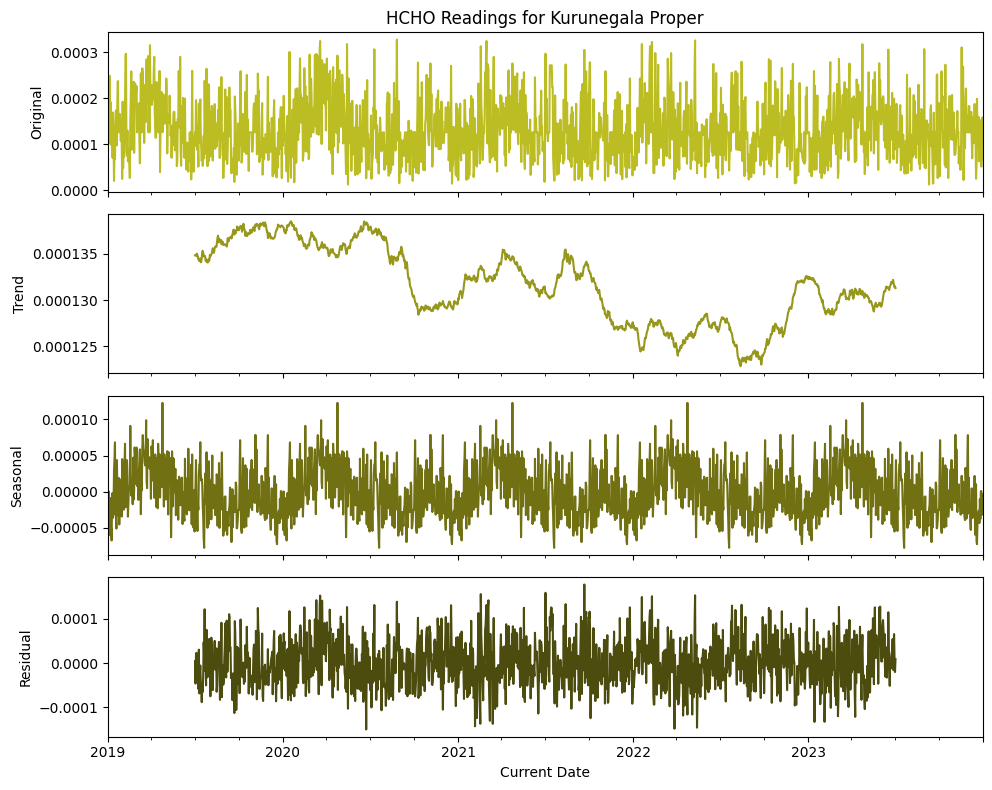

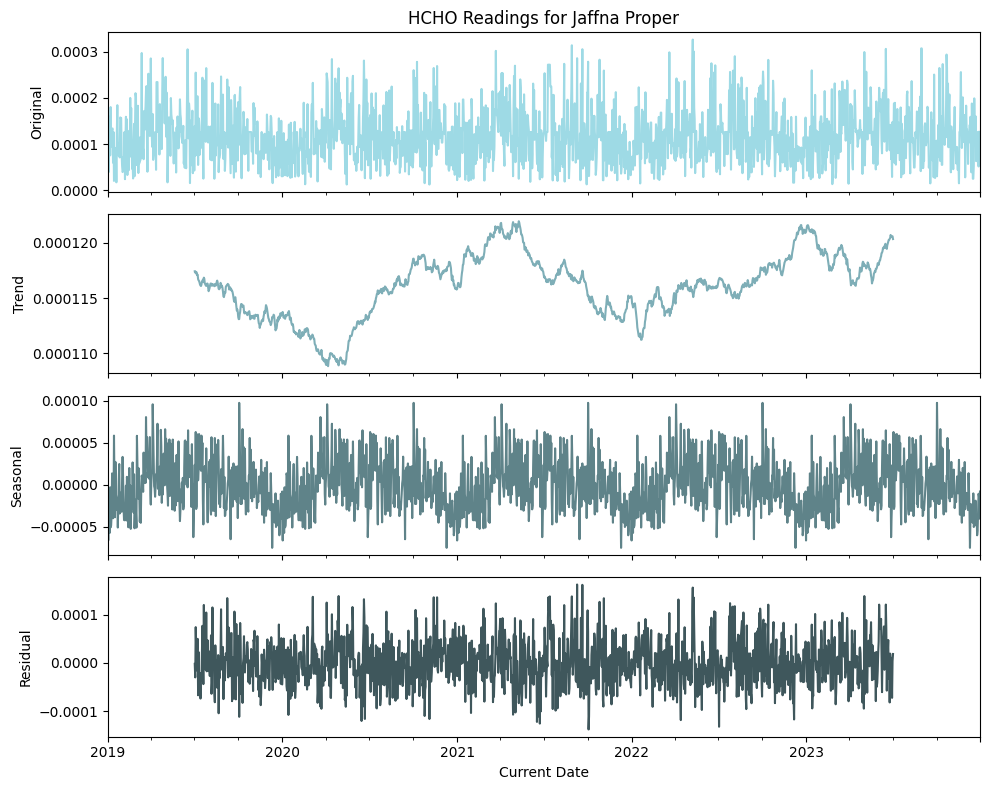

In [165]:
# Generate a list of base colors for each location
base_colors = plt.cm.tab20(np.linspace(0, 1, len(hcho_data['Location'].unique())))

for i, location in enumerate(hcho_data['Location'].unique()):
    # Select data for the current location
    location_data = hcho_data[hcho_data['Location'] == location].set_index('Current Date')

    # Decompose the time series
    decomposed = seasonal_decompose(location_data['HCHO Reading'], model='additive', period=365)

    # Generate lighter shades of the base color for different components
    orig_color = base_colors[i]
    trend_color = orig_color * np.array([0.8, 0.8, 0.8, 1])  # Lighter shade for trend
    seasonal_color = orig_color * np.array([0.6, 0.6, 0.6, 1])  # Lighter shade for seasonal
    resid_color = orig_color * np.array([0.4, 0.4, 0.4, 1])  # Lighter shade for residual

    # Plotting the original, trend, seasonal, and residual components
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    location_data['HCHO Reading'].plot(ax=axes[0], legend=False, title=f"HCHO Readings for {location}", color=orig_color)
    axes[0].set_ylabel('Original')
    decomposed.trend.plot(ax=axes[1], legend=False, color=trend_color)
    axes[1].set_ylabel('Trend')
    decomposed.seasonal.plot(ax=axes[2], legend=False, color=seasonal_color)
    axes[2].set_ylabel('Seasonal')
    decomposed.resid.plot(ax=axes[3], legend=False, color=resid_color)
    axes[3].set_ylabel('Residual')

    plt.tight_layout()
    plt.show()


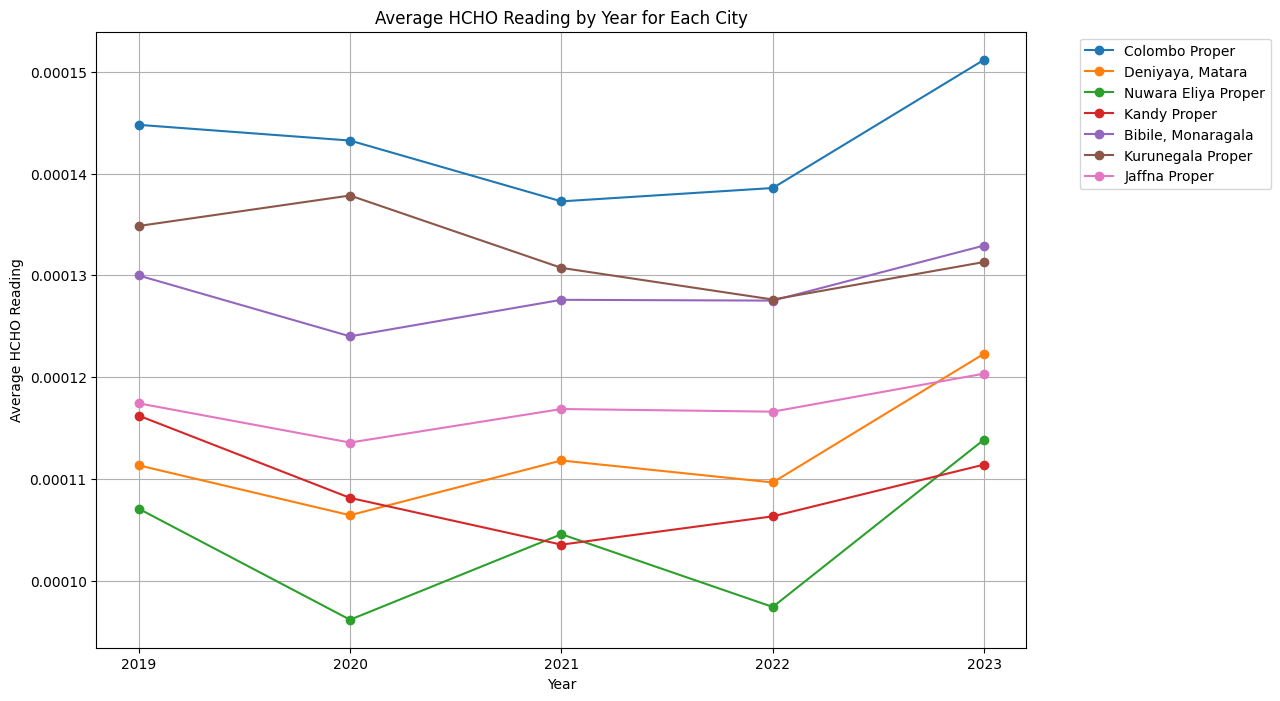

In [168]:
unique_cities = hcho_data['Location'].unique()
plt.figure(figsize=(12, 8))
for city in unique_cities:
    city_data = hcho_data[(hcho_data['Location'] == city)]
    yearly_avg_hcho = city_data.groupby('Year')['HCHO Reading'].mean()
    plt.plot(yearly_avg_hcho.index, yearly_avg_hcho.values, marker='o', linestyle='-', label=city)

plt.title('Average HCHO Reading by Year for Each City')
plt.xlabel('Year')
plt.ylabel('Average HCHO Reading')
plt.xticks(yearly_avg_hcho.index)  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()